**How to identify position players on a given date?**

**Problem:**
<br>
In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

**Strategy:**
<br>
- Focus on features of the batter (e.g. historical batting average) and pitcher (e.g. historical ERA, WHIP) to predict whether the batter would output a hit (or HR, single, double, etc.) in a given batter-pitcher at-bat matchup.

- If you choose a given date (e.g. May 9), you know the starting pitcher a batter would face. Use data to build a model taht predicts how well a batter would do against the pitcher as a guide for a decision. (Lower priority: If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. Similar players can be found by using Erdos score.)

- How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

- Validation: Historical data

This notebook was created within my "insight" virtual environment.

**Inputs and outputs**

*Version 1:*
- Input: Two players under consideration for one position and a date of interest (2019 season for historical validation).
- Output: Player recommendation for that position with a predicted score.

*Version 2:*
- Input: A participant's player roster (e.g. 20 players)
- Output: A recommended lineup.

Order of features of product to incorporate: (still to be determined)

0.  Try a simple model where each at-bat batter-pitcher matchup is simply its own row and selected features are done. (DONE)
1.	Roster’s “basic” baseball statistics from 2018 season? Or 50 games (including previous season) - (minimum viable product level) (DONE)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season) (DONE)
4.	Limit to more recent performance (last 100 at-bats games - dataframe for model does 200 rows)
5.	Weather, park effects, team defense, night/day, lineup order
6. Use batted ball characteristics as a feature of player and pitcher (launch angle average, launch speed average)
7.	Use of player similarity (lower priority)

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/


EDA, do HR over time and by date for each player


**Product pitch**

I'm creating a fantasy baseball application that suggests players on a given day. Fantasy baseball has over 11 million participants with the winners of leagues collecting entry fees and host platforms receiving a commission. The projected market for fantasy baseball in 2020 is over 8 billion dollars. A participant's success depends in part on daily player selection. For player selection, participants must rely on their own research or use a site's recommendation, which uses black-box algorithms behind pay walls. I'm developing an alternative algorithm to assist in player selection to save participants time and expose the important features in player performance prediction.

# Ideas

- Will hit happen based on pitch count
- Use last 100 at-bats from the date of interest.
- Use Bayesian?
- EDA  - plot someone's hits over game-dates as a time series
- Look at the player's last 100 hits 

Other:
- Use all info for at-bat and then do backwards selection.

**Motivation: Learning analytics requries some skills I can develop here**

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [2]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [3]:
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [95]:
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

<IPython.core.display.Javascript object>

In [4]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [981]:
# Code formatting with Jupyter black
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Database info

In [7]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [8]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

**Statcast data to database**
<br>
(done already, see previous versions of notebooks)

In [19]:
## create a database (if it doesn't exist)
# if not database_exists(engine.url):
#     create_database(engine.url)
# print(database_exists(engine.url))

<IPython.core.display.Javascript object>

In [ ]:
# This is done, but note it's out of order

# date_list = [
#     ("2019-03-20", "2019-09-29"),
#     ("2018-03-29", "2018-10-01"),
#     ("2017-04-02", "2017-10-01"),
# ]

# Above gave **2,174,906** pitch-by-pitch results in the database

#     ("2016-04-03", "2016-10-02"),   # didn't get
#     ("2015-04-05", "2015-10-04"),   # didn't get 


# for i, date_pair in enumerate(date_list):
#     if i < 1:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="replace")
#         print(date_pair, "replace mode")
#     else:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="append")
#         print(date_pair, "append mode")

In [20]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

See other notebook for more info



In [21]:
# Get player id
sql_query = """
SELECT * FROM player_id;
"""

df_player_id = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [11]:
# Batting stats

sql_query = """
SELECT * FROM batting_stats18_wpid;
"""

df_batting_stats_wpid = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [24]:
df_batting_stats_wpid.shape

(955, 300)

<IPython.core.display.Javascript object>

In [18]:
df_batting_stats_wpid.head()

,index,index_x,Season,Name,Team,Age,G,AB,PA,H,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,63,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,1,67,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,68,38,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,3,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0


<IPython.core.display.Javascript object>

In [22]:
# Pitching stats

sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

df_pitching_stats_wpid = pd.read_sql_query(sql_query, con)
# Limit to 2018, like with baseball stats
df_pitching_stats_wpid = df_pitching_stats_wpid[
    df_pitching_stats_wpid["Season"] == 2018
].copy()

<IPython.core.display.Javascript object>

In [23]:
df_pitching_stats_wpid.shape

(789, 310)

<IPython.core.display.Javascript object>

In [17]:
df_pitching_stats_wpid.head()

,index,Season,Name,Team,Age,W,L,ERA,WAR,G,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
1,1,2017.0,Chris Sale,Red Sox,28.0,17.0,8.0,2.90,7.6,32.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
2,2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
3,3,2019.0,Gerrit Cole,Astros,28.0,20.0,5.0,2.50,7.4,33.0,...,gerrit,cole,cole,gerrit,543037.0,coleg001,colege01,13125.0,2013.0,2019.0
4,1587,2018.0,Scott Kingery,Phillies,24.0,0.0,0.0,13.50,0.0,1.0,...,scott,kingery,kingery,scott,664068.0,kings001,kingesc01,17975.0,2018.0,2019.0


<IPython.core.display.Javascript object>

In [996]:
# Pitching stats

sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

df_pitching_stats_wpid = pd.read_sql_query(sql_query, con)
# Limit to 2019, like with baseball stats
df_pitching_stats19_wpid = df_pitching_stats_wpid[
    df_pitching_stats_wpid["Season"] == 2019
].copy()

<IPython.core.display.Javascript object>

In [997]:
df_pitching_stats19_wpid.head()

,index,Season,Name,Team,Age,W,L,ERA,WAR,G,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
3,3,2019.0,Gerrit Cole,Astros,28.0,20.0,5.0,2.50,7.4,33.0,...,gerrit,cole,cole,gerrit,543037.0,coleg001,colege01,13125.0,2013.0,2019.0
6,5,2019.0,Jacob deGrom,Mets,31.0,11.0,8.0,2.43,7.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
7,6,2019.0,Lance Lynn,Rangers,32.0,16.0,11.0,3.67,6.8,33.0,...,lance,lynn,lynn,lance,458681.0,lynnl001,lynnla01,2520.0,2011.0,2019.0
9,8,2019.0,Max Scherzer,Nationals,34.0,11.0,7.0,2.92,6.5,27.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
10,9,2019.0,Justin Verlander,Astros,36.0,21.0,6.0,2.58,6.4,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0


<IPython.core.display.Javascript object>

In [995]:
df_pitching_stats19_wpid.shape

(789, 310)

<IPython.core.display.Javascript object>

# Notes

## Contingencies

1. What if player has day off? or no game is scheduled?
2. What if player or pitcher doesn't have minimum nback at-bats?
3. What if player doesn't have minimum nback at-bats against same or opposite handedness?

**Quora answer on number of plate appearances**
https://www.quora.com/How-many-at-bats-does-the-average-MLB-player-go-through-per-year

One direction to go with is how many PA wpild a player accumulate if theu were to play every day, and not rest. That would be around 725. Though that total is not really an average as few players exceed such a total each year.

A second number would be how many plate appearances bases on normal rest during a season if a player never was injured, about 145-150 games for position players other then the catcher and 110 to 115 for catchers. Those totals would be around 650 and 450 respectively.

Yet another way to answer this would be the number of PA by all position players on a roster that were supposed to be starters, but may receive less playing time due to injury or a team developing, trading for or discovering a better player. That would probably be closer to 400.

You could also thing about all position players on a team including bench players, if we include them our total now is closer to 200-250.

Yet another way to look at this is to include all players on the roster including pitcher who may notbat intentionally. Include them and tour total is closer to 100-120.

## Other ideas


- Look at probabilities, instead of looking for 1 (done - not strong)
- Aggregate per game (potentially something there - not sure)
- Look at Ty France
- Add in pitcher info 
- See what pitches they're hitting, then see how that matches with pitchers 
- Remember that ultimately, we want to see that we're picking the right player - someone who has a higher probability overall will be better choice


**Motivation: Learning analytics requries some skills I can develop here**

## Questions to ask

- Am I inputting handedness correctly? How to input values if they're transformed in the model? (L -1.41421356, R 0.70710678)
- Add pitcher specific ID as a factor?


## Things to fix

- Why is dataframe model going to <200 - cause of the day of separation.
- Standardize train-test before split

# Valid for higher probability of predicting 1 identifies better player?

- Do models for each player and look at probabilities of outputting 1

- try joining DFs?
- weighting?

## Input both batters and date

SQL query gets everything **before** the date. The validation and checking gets data on the day of.

In [911]:
# FUNCTION FOR GETTING STATCAST DATA

# Enter key_mlbam (Mike Trout, ESPN rank 1)
# pid_of_interest1 = 545361
# Enter key_mlbam (Jesse Winker, ESPN rank 280)
# pid_of_interest2 = 608385

# Enter key_mlbam (Mookie Betts, ESPN rank 2?)
# pid_of_interest1 = 605141

# Reynolds (668804, Bryan Reynolds (PIT))
pid_of_interest1 = 668804

# Enter key_mlbam (Leury Garcia, ESPN rank 300)
pid_of_interest2 = 544725

date_of_interest = "'2019-09-04'"  # Note internal single quotes

no_total_ab_events = 1000

# Note: SQL union of two different searches doesn't preserve order
# It's easier to make a dataframe for each player
# https://stackoverflow.com/questions/21181664/sql-server-union-but-keep-order/21181766
# ---------------------------------------------------

<IPython.core.display.Javascript object>

In [912]:
def get_sc_batter_df(player_id, date, n_ab_events):
    sql_query = (
        """
    (SELECT * FROM statcast 
    JOIN player_id ON statcast.batter=player_id.key_mlbam 
    WHERE statcast.batter= 
    """
        + str(player_id)
        + """
    AND statcast.game_date<=
    """
        + str(date)
        + """ 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
    LIMIT
    """
        + str(n_ab_events)
        + ");"
    )

    # print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)
    df_sc_events.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

    return df_sc_events

<IPython.core.display.Javascript object>

In [913]:
df_sc_events_b1 = get_sc_batter_df(pid_of_interest1, date_of_interest, 1000)
df_sc_events_b2 = get_sc_batter_df(pid_of_interest2, date_of_interest, 1000)

<IPython.core.display.Javascript object>

In [914]:
df_sc_events_b1.head(10)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SL,2019-09-04,85.8,-1.9598,5.8343,Jose Urena,668804.0,570632.0,single,hit_into_play_score,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
1,FF,2019-09-04,95.7,3.0704,5.9168,Adam Conley,668804.0,543045.0,strikeout,swinging_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
2,CU,2019-09-04,72.4,-2.5206,4.9159,Robert Dugger,668804.0,667498.0,field_out,hit_into_play,...,Strategic,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
3,FF,2019-09-04,89.4,-2.3685,4.9172,Robert Dugger,668804.0,667498.0,double,hit_into_play_no_out,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
4,FT,2019-09-04,90.4,-2.5811,4.8695,Robert Dugger,668804.0,667498.0,field_error,hit_into_play_no_out,...,Strategic,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
5,FT,2019-09-03,97.6,-2.1865,5.7700,Jose Urena,668804.0,570632.0,field_out,hit_into_play,...,Standard,Strategic,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
6,FF,2019-09-03,95.0,1.9998,5.8492,Jarlin Garcia,668804.0,606424.0,strikeout,called_strike,...,Strategic,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
7,FF,2019-09-03,95.8,-2.2007,5.8480,Sandy Alcantara,668804.0,645261.0,field_out,hit_into_play,...,Strategic,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
8,FF,2019-09-03,96.5,-2.4874,5.8048,Sandy Alcantara,668804.0,645261.0,field_out,hit_into_play,...,Infield shift,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
9,FF,2019-09-03,96.9,-2.4392,6.0714,Sandy Alcantara,668804.0,645261.0,strikeout,called_strike,...,Infield shift,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0


<IPython.core.display.Javascript object>

In [915]:
df_sc_events_b2.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FF,2019-09-04,91.9,2.8175,6.0013,Brad Hand,544725.0,543272.0,single,hit_into_play_no_out,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
1,KC,2019-09-04,83.2,-1.3917,5.7539,Shane Bieber,544725.0,669456.0,strikeout,swinging_strike_blocked,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
2,KC,2019-09-04,82.5,-1.5268,5.7392,Shane Bieber,544725.0,669456.0,force_out,hit_into_play,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
3,KC,2019-09-04,83.7,-1.4992,5.8262,Shane Bieber,544725.0,669456.0,strikeout,swinging_strike_blocked,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
4,CH,2019-09-04,87.6,-1.6473,5.7523,Shane Bieber,544725.0,669456.0,single,hit_into_play_no_out,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0


<IPython.core.display.Javascript object>

In [916]:
def plot_events_over_time(sc_events_df, ev_list):
    df_temp = sc_events_df.copy()
    df_temp = df_temp[df_temp["game_date"].between("2019-04-01", "2019-09-09")]
    df_temp.reset_index(inplace=True)

    # Encode on-base events, including walks
    df_temp["event_code"] = 0
    df_temp.loc[df_temp["events"].isin(ev_list), "event_code"] = 1

    f, ax1 = plt.subplots()
    ax1.scatter(
        df_temp["game_date"],
        df_temp["event_code"] + np.random.normal(0, 0.01, len(df_temp)),
        facecolors="none",
        edgecolors="black",
    )

    # figure out date formatting
    # ax1.xticks(rotation=45)
    #     xlocs, xlabels = ax1.xticks()
    #     ax1.set_xticklabels(xlabels, rotation=45)  # to Rotate Xticks Label Text

    return df_temp[["events", "event_code"]].head(10)

<IPython.core.display.Javascript object>

,events,event_code
0,single,1
1,strikeout,0
2,field_out,0
3,double,1
4,field_error,0
5,field_out,0
6,strikeout,0
7,field_out,0
8,field_out,0
9,strikeout,0


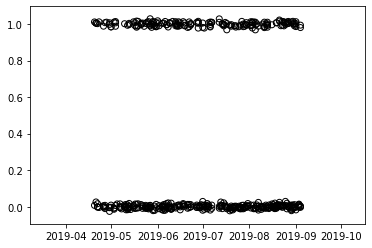

<IPython.core.display.Javascript object>

In [917]:
event_list = ["walk", "single", "double", "triple", "home_run"]
plot_events_over_time(df_sc_events_b1, event_list)

,events,event_code
0,single,1
1,strikeout,0
2,force_out,0
3,strikeout,0
4,single,1
5,strikeout,0
6,single,1
7,field_out,0
8,strikeout,0
9,strikeout,0


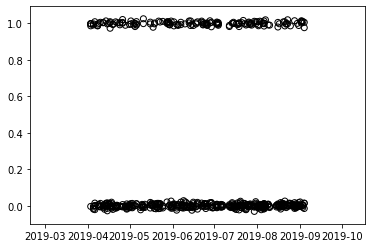

<IPython.core.display.Javascript object>

In [918]:
event_list = ["walk", "single", "double", "triple", "home_run"]
plot_events_over_time(df_sc_events_b2, event_list)

In [919]:
# def get_model_prob(df4model)

# Output probabilities of

<IPython.core.display.Javascript object>

In [920]:
def get_df4model(df, n_back_PA, m_size):
    """
    Function for getting summarized DF
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200
    # -------------------------

    # Reset index so that code below works
    df.reset_index(inplace=True)

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak
    df["num_events_sum_nback"] = (
        df["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]
    )

    # Percent of on-base events (overall)
    df["prop_events_nback"] = df["num_events_sum_nback"] / n_back_PA

    # Percent of on-base events against handedness of pitcher
    for i in df.index:
        p_throws = df["p_throws"].iloc[i]  # Get handedness of pitcher
        df_pt_throw = df[df["p_throws"] == p_throws]
        n_pt_events = df_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
        df.loc[i, "num_events_sum_nback_pt"] = n_pt_events
        df.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]

    df_4model = df[col4model].copy()
    df_4model_overall = df_4model.loc[:m_size]

    df_meta_w_model_overall = pd.merge(
        df[["game_date", "inning", "outs_when_up", "events", "player_name", "pitcher"]],
        df_4model_overall,
        left_index=True,
        right_index=True,
    )

    return df_meta_w_model_overall

<IPython.core.display.Javascript object>

In [921]:
df_sc_events_b1.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SL,2019-09-04,85.8,-1.9598,5.8343,Jose Urena,668804.0,570632.0,single,hit_into_play_score,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
1,FF,2019-09-04,95.7,3.0704,5.9168,Adam Conley,668804.0,543045.0,strikeout,swinging_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
2,CU,2019-09-04,72.4,-2.5206,4.9159,Robert Dugger,668804.0,667498.0,field_out,hit_into_play,...,Strategic,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
3,FF,2019-09-04,89.4,-2.3685,4.9172,Robert Dugger,668804.0,667498.0,double,hit_into_play_no_out,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
4,FT,2019-09-04,90.4,-2.5811,4.8695,Robert Dugger,668804.0,667498.0,field_error,hit_into_play_no_out,...,Strategic,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0


<IPython.core.display.Javascript object>

In [922]:
df4model_b1 = get_df4model(df=df_sc_events_b1.copy(), n_back_PA=100, m_size=200)

<IPython.core.display.Javascript object>

In [923]:
df4model_b1.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-04,9.0,0.0,single,Jose Urena,570632.0,1,R,0.36,0.42
1,2019-09-04,7.0,0.0,strikeout,Adam Conley,543045.0,0,L,0.35,0.26
2,2019-09-04,4.0,2.0,field_out,Robert Dugger,667498.0,0,R,0.35,0.42
3,2019-09-04,3.0,0.0,double,Robert Dugger,667498.0,1,R,0.35,0.41
4,2019-09-04,1.0,1.0,field_error,Robert Dugger,667498.0,0,R,0.35,0.41


<IPython.core.display.Javascript object>

In [924]:
print(df4model_b1.head())
print(df4model_b1.shape)

   game_date  inning  outs_when_up       events    player_name   pitcher  \
0 2019-09-04     9.0           0.0       single     Jose Urena  570632.0   
1 2019-09-04     7.0           0.0    strikeout    Adam Conley  543045.0   
2 2019-09-04     4.0           2.0    field_out  Robert Dugger  667498.0   
3 2019-09-04     3.0           0.0       double  Robert Dugger  667498.0   
4 2019-09-04     1.0           1.0  field_error  Robert Dugger  667498.0   

   event_code p_throws  prop_events_nback  prop_events_sum_nback_pt  
0           1        R               0.36                      0.42  
1           0        L               0.35                      0.26  
2           0        R               0.35                      0.42  
3           1        R               0.35                      0.41  
4           0        R               0.35                      0.41  
(201, 10)


<IPython.core.display.Javascript object>

In [925]:
df4model_b2 = get_df4model(df=df_sc_events_b2.copy(), n_back_PA=100, m_size=200)

<IPython.core.display.Javascript object>

In [926]:
print(df4model_b2.head())
print(df4model_b2.shape)

   game_date  inning  outs_when_up     events   player_name   pitcher  \
0 2019-09-04     9.0           1.0     single     Brad Hand  543272.0   
1 2019-09-04     7.0           2.0  strikeout  Shane Bieber  669456.0   
2 2019-09-04     5.0           0.0  force_out  Shane Bieber  669456.0   
3 2019-09-04     2.0           2.0  strikeout  Shane Bieber  669456.0   
4 2019-09-04     1.0           0.0     single  Shane Bieber  669456.0   

   event_code p_throws  prop_events_nback  prop_events_sum_nback_pt  
0           1        L               0.23                      0.29  
1           0        R               0.22                      0.24  
2           0        R               0.22                      0.24  
3           0        R               0.23                      0.25  
4           1        R               0.23                      0.24  
(201, 10)


<IPython.core.display.Javascript object>

In [927]:
print(pid_of_interest1, pid_of_interest2)

668804 544725


<IPython.core.display.Javascript object>

## EDA

Text(0, 0.5, 'event rate')

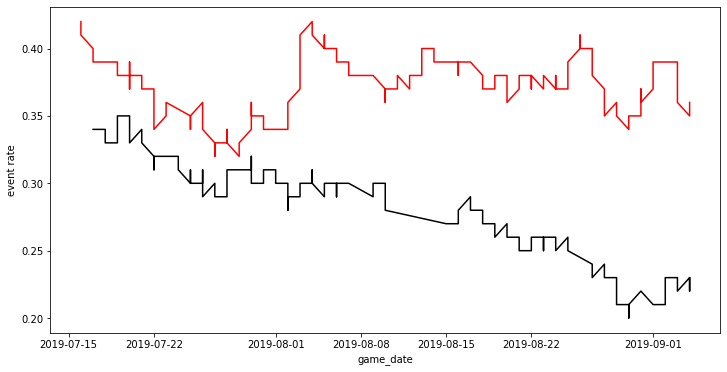

<IPython.core.display.Javascript object>

In [928]:
# Lineplot of each player

# Sanity checking that df is in order
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df4model_b1["game_date"], df4model_b1["prop_events_nback"], c='red', label='Player A (M. Trout)')
ax1.set_xlabel("game_date")

ax1.plot(df4model_b2["game_date"], df4model_b2["prop_events_nback"], c='black', label='Player B (L. Garcia)')
ax1.set_xlabel("game_date")
ax1.set_ylabel('event rate')


Text(0.5, 0, 'proportion of event')

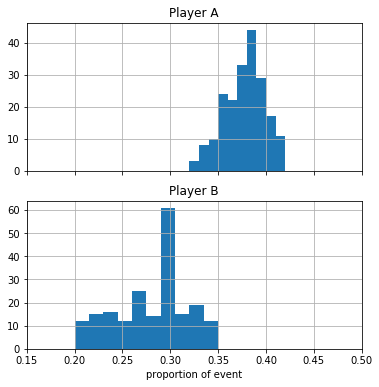

<IPython.core.display.Javascript object>

In [929]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
df4model_b1["prop_events_nback"].hist(ax=ax1)
ax1.set_xlim([0.15, 0.5])
ax1.set_title("Player A")

df4model_b2["prop_events_nback"].hist(ax=ax2)
ax2.set_xlim([0.15, 0.5])
ax2.set_title("Player B")
ax2.set_xlabel("proportion of event")

In [931]:
print(
    round(df4model_b1["prop_events_nback"].mean(), 3),
    round(df4model_b2["prop_events_nback"].mean(), 3),
)

0.373 0.279


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Player 2 (overall)')

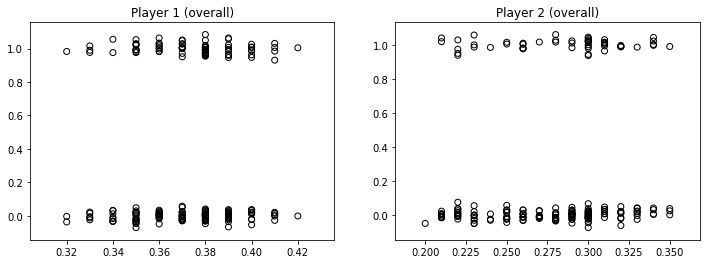

<IPython.core.display.Javascript object>

In [932]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(
    df4model_b1["prop_events_nback"],
    df4model_b1["event_code"] + np.random.normal(0, 0.025, len(df4model_b1)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 1 (overall)")

ax2.scatter(
    df4model_b2["prop_events_nback"],
    df4model_b2["event_code"] + np.random.normal(0, 0.025, len(df4model_b2)),
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("Player 2 (overall)")

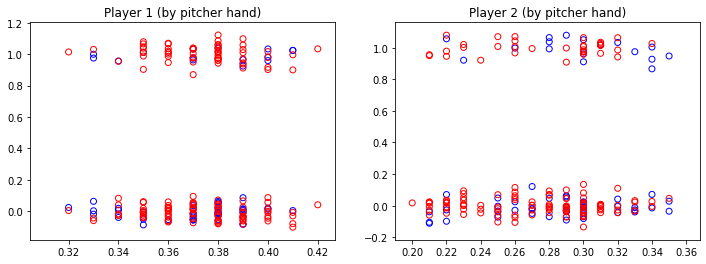

<IPython.core.display.Javascript object>

In [933]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
c_hand_list = ["blue", "red"]

for i, hand in enumerate(["L", "R"]):
    df4model_b1_hand = df4model_b1[df4model_b1["p_throws"] == hand].copy()
    df4model_b2_hand = df4model_b2[df4model_b2["p_throws"] == hand].copy()

    ax1.scatter(
        df4model_b1_hand["prop_events_nback"],
        df4model_b1_hand["event_code"]
        + +np.random.normal(0, 0.05, len(df4model_b1_hand)),
        facecolors="none",
        edgecolors=c_hand_list[i],
    )
    ax1.set_title("Player 1 (by pitcher hand)")

    ax2.scatter(
        df4model_b2_hand["prop_events_nback"],
        df4model_b2_hand["event_code"]
        + np.random.normal(0, 0.05, len(df4model_b2_hand)),
        facecolors="none",
        edgecolors=c_hand_list[i],
    )
    ax2.set_title("Player 2 (by pitcher hand)")

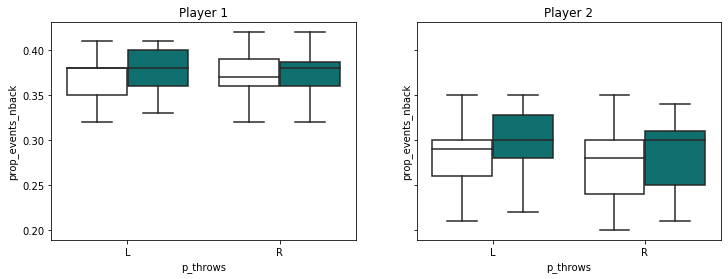

<IPython.core.display.Javascript object>

In [934]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(
    x="p_throws",
    hue="event_code",
    y="prop_events_nback",
    data=df4model_b1,
    palette=["w", "teal"],
    order=["L", "R"],
    hue_order=[0, 1],
    ax=ax1,
)
ax1.set_title("Player 1")
ax1.get_legend().remove()

sns.boxplot(
    x="p_throws",
    hue="event_code",
    y="prop_events_nback",
    data=df4model_b2,
    palette=["w", "teal"],
    order=["L", "R"],
    hue_order=[0, 1],
    ax=ax2,
)
ax2.set_title("Player 2")
ax2.get_legend().remove()

In [935]:
groupA1_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'L') & (df4model_b1["event_code"] == 0), "prop_events_nback"]
groupA2_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'L') & (df4model_b1["event_code"] == 1), "prop_events_nback"]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]
print("Player A vs. LHP, MW: ", mw_p_A, "Player A vs. LHP, t-test: ", ttest_p_A)

groupB1_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'R') & (df4model_b1["event_code"] == 0), "prop_events_nback"]
groupB2_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'R') & (df4model_b1["event_code"] == 1), "prop_events_nback"]

mw_p_B = mannwhitneyu(groupB1_vals, groupB2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_B = ttest_ind(groupB1_vals, groupB2_vals, equal_var=False)[1]
print("Player A vs. RHP, MW: ", mw_p_B, "Player A vs. RHP, t-test: ", ttest_p_B)


Player A vs. LHP, MW:  0.1570198037267942 Player A vs. LHP, t-test:  0.43794222978048614
Player A vs. RHP, MW:  0.3902744111238652 Player A vs. RHP, t-test:  0.791958996767719


<IPython.core.display.Javascript object>

In [936]:
groupA1_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'L') & (df4model_b2["event_code"] == 0), "prop_events_nback"]
groupA2_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'L') & (df4model_b2["event_code"] == 1), "prop_events_nback"]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]
print("Player B vs. LHP, MW: ", mw_p_A, "Player B vs. LHP, t-test: ", ttest_p_A)

groupb2_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'R') & (df4model_b2["event_code"] == 0), "prop_events_nback"]
groupB2_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'R') & (df4model_b2["event_code"] == 1), "prop_events_nback"]

mw_p_B = mannwhitneyu(groupb2_vals, groupB2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_B = ttest_ind(groupb2_vals, groupB2_vals, equal_var=False)[1]
print("Player B vs. RHP, MW: ", mw_p_B, "Player B vs. RHP, t-test: ", ttest_p_B)


Player B vs. LHP, MW:  0.08498558771377174 Player B vs. LHP, t-test:  0.1949851865051548
Player B vs. RHP, MW:  0.17369298762047164 Player B vs. RHP, t-test:  0.522985948121288


<IPython.core.display.Javascript object>

## Logistic regression

### Separate "day of" from "pre-date" data

In [937]:
df4model_dayof_b1 = df4model_b1[df4model_b1["game_date"] == date_of_interest].copy()
df4model_dayof_b1

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-04,9.0,0.0,single,Jose Urena,570632.0,1,R,0.36,0.42
1,2019-09-04,7.0,0.0,strikeout,Adam Conley,543045.0,0,L,0.35,0.26
2,2019-09-04,4.0,2.0,field_out,Robert Dugger,667498.0,0,R,0.35,0.42
3,2019-09-04,3.0,0.0,double,Robert Dugger,667498.0,1,R,0.35,0.41
4,2019-09-04,1.0,1.0,field_error,Robert Dugger,667498.0,0,R,0.35,0.41


<IPython.core.display.Javascript object>

In [938]:
df4model_dayof_b2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()
df4model_dayof_b2

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-04,9.0,1.0,single,Brad Hand,543272.0,1,L,0.23,0.29
1,2019-09-04,7.0,2.0,strikeout,Shane Bieber,669456.0,0,R,0.22,0.24
2,2019-09-04,5.0,0.0,force_out,Shane Bieber,669456.0,0,R,0.22,0.24
3,2019-09-04,2.0,2.0,strikeout,Shane Bieber,669456.0,0,R,0.23,0.25
4,2019-09-04,1.0,0.0,single,Shane Bieber,669456.0,1,R,0.23,0.24


<IPython.core.display.Javascript object>

In [939]:
col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]
df4model_b1_lim = df4model_b1.loc[
    df4model_b1["game_date"] < date_of_interest, col4model
].copy()

df4model_b2_lim = df4model_b2.loc[
    df4model_b2["game_date"] < date_of_interest, col4model
].copy()


# df4model_b1_lim = df4model_b1[col4model].copy()
# df4model_b2_lim = df4model_b2[col4model].copy()

<IPython.core.display.Javascript object>

In [940]:
pd.concat([df4model_b1_lim.head(), df4model_b2_lim.head()], axis=1)

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
5,0,R,0.36,0.41,0,R,0.22,0.24
6,0,L,0.37,0.29,1,R,0.22,0.23
7,0,R,0.38,0.41,0,R,0.22,0.24
8,0,R,0.38,0.41,0,R,0.22,0.24
9,0,R,0.39,0.42,0,R,0.23,0.24


<IPython.core.display.Javascript object>

In [941]:
# FUNCTION TO REPLACE CATEGORICAL INPUT
df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

In [942]:
# f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))

# df4model_b1_lim["prop_events_nback"].hist(ax=ax1)
# ax1.set_title("overall events, player 1")

# df_temp = df4model_b1_lim[df4model_b1_lim["p_throws"] == 0]
# df_temp["prop_events_nback"].hist(ax=ax2)
# ax2.set_title("events against left-handers, player 1")

# df_temp = df4model_b1_lim[df4model_b1_lim["p_throws"] == 1]
# df_temp["prop_events_nback"].hist(ax=ax3)
# ax3.set_title("events against right-handers, player 1")

# df4model_p2["prop_events_nback"].hist(ax=ax4)
# ax4.set_title("overall events, player 2")

# df_temp = df4model_p2[df4model_p2["p_throws"] == 0]
# df_temp["prop_events_nback"].hist(ax=ax5)
# ax5.set_title("events against left-handers, player 2")

# df_temp = df4model_p2[df4model_p2["p_throws"] == 1]
# df_temp["prop_events_nback"].hist(ax=ax6)
# ax6.set_title("events against right-handers, player 2")

# plt.tight_layout()

<IPython.core.display.Javascript object>

In [943]:
def get_split_data(df4model, testsize):
    y = df4model["event_code"]
    X = df4model.iloc[:, 1::]

    # Scale features based on training data
    std_scale = StandardScaler()
    X_scale = std_scale.fit_transform(X)

    X_train_scale, X_test_scale, y_train, y_test = train_test_split(
        X_scale, y, test_size=testsize, random_state=19
    )

    return X_train_scale, X_test_scale, y_train, y_test

<IPython.core.display.Javascript object>

In [944]:
df4model_b1_lim.shape

(196, 4)

<IPython.core.display.Javascript object>

In [945]:
df4model_b2_lim.shape

(196, 4)

<IPython.core.display.Javascript object>

In [946]:
X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
    df4model_b1_lim, 0.4
)
X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
    df4model_b2_lim, 0.4
)

<IPython.core.display.Javascript object>

In [947]:
print(X_train_scale_b1.shape, X_test_scale_b1.shape, y_train_b1.shape, y_test_b1.shape)
print(X_train_scale_b2.shape, X_test_scale_b2.shape, y_train_b2.shape, y_test_b2.shape)

(117, 3) (79, 3) (117,) (79,)
(117, 3) (79, 3) (117,) (79,)


<IPython.core.display.Javascript object>

In [948]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression()
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [949]:
# Run models
log_reg_b1, df_eval_b1 = run_logreg_model(
    X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
)

log_reg_b2, df_eval_b2 = run_logreg_model(
    X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
)

<IPython.core.display.Javascript object>

In [951]:
pd.concat([df_eval_b1.reset_index().head(), df_eval_b2.reset_index().head()], axis=1)

,index,test,pred,predprob,index,test,pred,predprob
0,36,1,0,0.265110,36,0,0,0.234481
1,155,1,0,0.464191,155,0,0,0.198830
2,149,1,0,0.445860,149,1,0,0.227086
3,42,1,0,0.230213,42,0,0,0.272737
4,141,0,0,0.099927,141,0,0,0.250035


<IPython.core.display.Javascript object>

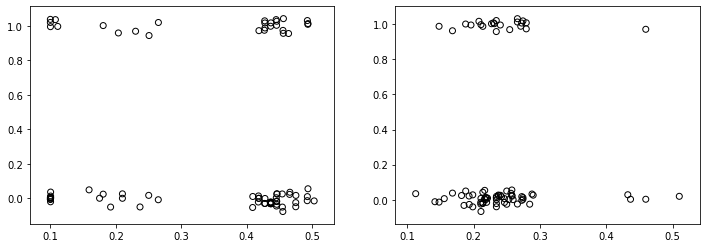

<IPython.core.display.Javascript object>

In [952]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(
    df_eval_b1["predprob"],
    df_eval_b1["test"] + np.random.normal(0, 0.025, len(df_eval_b1)),
    facecolors="none",
    edgecolors="black",
)

ax2.scatter(
    df_eval_b2["predprob"],
    df_eval_b2["test"] + np.random.normal(0, 0.025, len(df_eval_b2)),
    facecolors="none",
    edgecolors="black",
)

In [953]:
print("Player 1 coefficients: ", log_reg_b1.coef_)
print("Player 2 coefficients: ", log_reg_b2.coef_)

Player 1 coefficients:  [[0.14236542 0.00191787 0.58597128]]
Player 2 coefficients:  [[-0.03456852  0.34511474 -0.40894548]]


<IPython.core.display.Javascript object>

In [456]:
# INPUT HANDEDNESS CORRECTLY - it's transformed

# L -1.41421356
# R 0.70710678


<IPython.core.display.Javascript object>

## Output for new case - check this

In [954]:
# "Day of" data was extracted above

# col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]
# This variable was already assigned above - just put here as a reminder

# Get up to last 3 at-bats for the input
df4model_dayof_4model_b1 = df4model_dayof_b1[col4model].iloc[-3:, :].copy()
df4model_dayof_4model_b2 = df4model_dayof_b2[col4model].iloc[-3:, :].copy()

# replace categorical input
df4model_dayof_4model_b1["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df4model_dayof_4model_b2["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

### Predict and compare to real performance

In [955]:
df4model_dayof_4model_b1

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
2,0,1,0.35,0.42
3,1,1,0.35,0.41
4,0,1,0.35,0.41


<IPython.core.display.Javascript object>

In [956]:
df4model_dayof_4model_b2

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
2,0,1,0.22,0.24
3,0,1,0.23,0.25
4,1,1,0.23,0.24


<IPython.core.display.Javascript object>

In [957]:
def return_series_of_player_prediction(
    df4model_dayof_b1, df4model_dayof_b2, log_reg_b1, log_reg_b2
):
    s_new_case = pd.Series()

    df4model_dayof_b1 = df4model_dayof_4model_b1.copy()
    df4model_dayof_b2 = df4model_dayof_4model_b2.copy()

    # actual performance
    s_new_case["actual_performance_batterA"] = df4model_dayof_b1.reset_index()[
        "event_code"
    ].mean()
    s_new_case["actual_performance_batterB"] = df4model_dayof_b2.reset_index()[
        "event_code"
    ].mean()

    # ADD VARIANCE - TBD
    s_new_case["pred_var_batterA"] = None
    s_new_case["pred_var_batterB"] = None

    # vs actual pitcher
    s_new_case["pred_vs_gamepitcher_batterA"] = log_reg_b1.predict_proba(
        df4model_dayof_b1.iloc[:, 1:]
    )[:, 1].mean()

    s_new_case["pred_vs_gamepitcher_batterB"] = log_reg_b2.predict_proba(
        df4model_dayof_b2.iloc[:, 1:]
    )[:, 1].mean()

    # Prediction
    if (
        s_new_case["pred_vs_gamepitcher_batterA"]
        > s_new_case["pred_vs_gamepitcher_batterB"]
    ):
        predict_for_day = "predict_A"
    elif (
        s_new_case["pred_vs_gamepitcher_batterA"]
        == s_new_case["pred_vs_gamepitcher_batterB"]
    ):
        predict_for_day = "even"
    else:
        predict_for_day = "predict_B"

    # Actual case
    if (
        s_new_case["actual_performance_batterA"]
        > s_new_case["actual_performance_batterB"]
    ):
        actual_for_day = "actual_A"

    elif (
        s_new_case["actual_performance_batterA"]
        == s_new_case["actual_performance_batterB"]
    ):
        actual_for_day = "even"
    else:
        actual_for_day = "actual_B"

    validation_entries = (
        date_of_interest,
        pid_of_interest1,
        pid_of_interest2,
        predict_for_day,
        actual_for_day,
    )

    return s_new_case, validation_entries

<IPython.core.display.Javascript object>

In [655]:
# May not need
# def return_df_of_player_prediction(df4model_dayof_b1, df4model_dayof_b2):

#     df_new_case = pd.DataFrame()

#     # actual performance
#     df_new_case["actual_performance_batterA"] = df4model_dayof_b1.reset_index()[
#         "event_code"
#     ]
#     df_new_case["actual_performance_batterB"] = df4model_dayof_b2.reset_index()[
#         "event_code"
#     ]

#     # ADD VARIANCE - TBD
#     df_new_case["pred_var_batterA"] = None
#     df_new_case["pred_var_batterB"] = None

#     # vs actual pitcher
#     df_new_case["pred_vs_gamepitcher_batterA"] = log_reg_b1.predict_proba(
#         df4model_dayof_b1.iloc[:, 1:]
#     )[:, 1]

#     df_new_case["pred_vs_gamepitcher_batterB"] = log_reg_b2.predict_proba(
#         df4model_dayof_b2.iloc[:, 1:]
#     )[:, 1]

#     #     # vs LHP pitcher - player A
#     #     df_temp_left = df4model_dayof_b1.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [0] * len(df4model_dayof_4model_b1)
#     #     df_new_case["pred_vs_LHP_batterA"] = log_reg_b1.predict_proba(df_temp_left)[:, 1]

#     #     # vs LHP pitcher - player B
#     #     df_temp_left = df4model_dayof_b2.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [0] * len(df4model_dayof_b2)
#     #     df_new_case["pred_vs_LHP_batterB"] = log_reg_b2.predict_proba(df_temp_left)[:, 1]

#     #     # vs RHP pitcher - player A
#     #     df_temp_left = df4model_dayof_b1.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [1] * len(df4model_dayof_b1)
#     #     df_new_case["pred_vs_RHP_batterA"] = log_reg_b1.predict_proba(df_temp_left)[:, 1]

#     #     # vs RHP pitcher - player B
#     #     df_temp_left = df4model_dayof_b2.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [1] * len(df4model_dayof_b2)
#     #     df_new_case["pred_vs_RHP_batterB"] = log_reg_b2.predict_proba(df_temp_left)[:, 1]

#     # Prediction
#     if (
#         df_new_case["pred_vs_gamepitcher_batterA"].mean()
#         > df_new_case["pred_vs_gamepitcher_batterB"].mean()
#     ):
#         predict_for_day = "predict_A"
#     else:
#         predict_for_day = "predict_B"

#     # Actual case
#     if (
#         df_new_case["actual_performance_batterA"].mean()
#         > df_new_case["actual_performance_batterB"].mean()
#     ):
#         actual_for_day = "actual_A"
#     else:
#         actual_for_day = "actual_B"

#     validation_entries = (
#         date_of_interest,
#         pid_of_interest1,
#         pid_of_interest2,
#         predict_for_day,
#         actual_for_day,
#     )

#     return df_new_case, validation_entries

<IPython.core.display.Javascript object>

In [958]:
return_series_of_player_prediction(
    df4model_dayof_4model_b1, df4model_dayof_4model_b2, log_reg_b1, log_reg_b2
)

(actual_performance_batterA     0.333333
 actual_performance_batterB     0.333333
 pred_var_batterA                   None
 pred_var_batterB                   None
 pred_vs_gamepitcher_batterA    0.436708
 pred_vs_gamepitcher_batterB    0.231098
 dtype: object, ("'2019-09-04'", 668804, 544725, 'predict_A', 'even'))

<IPython.core.display.Javascript object>

## Assessments

In [959]:
# Look at r2 value  - predicts variance - but there's lots of zeros

log_reg_p1.score(X_train_scale_p1, y_train_p1)

0.625

<IPython.core.display.Javascript object>

In [960]:
log_reg_p1.score(X_test_scale_p1, y_test_p1)

0.6172839506172839

<IPython.core.display.Javascript object>

In [961]:
print(metrics.classification_report(y_test_p1, y_pred_p1))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       0.00      0.00      0.00        31

    accuracy                           0.62        81
   macro avg       0.31      0.50      0.38        81
weighted avg       0.38      0.62      0.47        81



/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

In [962]:
log_reg_p2.score(X_train_scale_p2, y_train_p2)

0.725

<IPython.core.display.Javascript object>

In [963]:
log_reg_p2.score(X_test_scale_p2, y_test_p2)

0.7283950617283951

<IPython.core.display.Javascript object>

In [964]:
print(metrics.classification_report(y_test_p2, y_pred_p2))

              precision    recall  f1-score   support

           0       0.75      0.97      0.84        61
           1       0.00      0.00      0.00        20

    accuracy                           0.73        81
   macro avg       0.37      0.48      0.42        81
weighted avg       0.56      0.73      0.63        81



<IPython.core.display.Javascript object>

In [ ]:
# Add validation for similar players and different dates
# Use a set of outfielders and dates

## VALIDATION with multiple dates

### Easy case - one player excellent, one not as good

In [883]:
# Betts and Garcia (605141, 544725)
pid1 = 605141
pid2 = 544725

# (43 dates)
# date_list = ["'2019-07-16'",
#  "'2019-07-17'",
#  "'2019-07-18'",
#  "'2019-07-19'",
#  "'2019-07-20'",
#  "'2019-07-21'",
#  "'2019-07-22'",
#  "'2019-07-23'",
#  "'2019-07-24'",
#  "'2019-07-25'",
#  "'2019-07-26'",
#  "'2019-07-27'",
#  "'2019-07-28'",
#  "'2019-07-30'",
#  "'2019-07-31'",
#  "'2019-08-01'",
#  "'2019-08-02'",
#  "'2019-08-03'",
#  "'2019-08-04'",
#  "'2019-08-05'",
#  "'2019-08-06'",
#  "'2019-08-07'",
#  "'2019-08-09'",
#  "'2019-08-10'",
#  "'2019-08-16'",
#  "'2019-08-17'",
#  "'2019-08-18'",
#  "'2019-08-20'",
#  "'2019-08-21'",
#  "'2019-08-23'",
#  "'2019-08-24'",
#  "'2019-08-25'",
#  "'2019-08-27'",
#  "'2019-08-28'",
#  "'2019-08-30'",
#  "'2019-08-31'",
#  "'2019-09-01'",
#  "'2019-09-03'",
#  "'2019-09-04'",
#  "'2019-09-10'",
#  "'2019-09-12'",
#  "'2019-09-21'",
#  "'2019-09-24']

# (12 dates)
date_list = [
    "'2019-08-25'",
    "'2019-08-27'",
    "'2019-08-28'",
    "'2019-08-30'",
    "'2019-08-31'",
    "'2019-09-01'",
    "'2019-09-03'",
    "'2019-09-04'",
    "'2019-09-10'",
    "'2019-09-12'",
    "'2019-09-21'",
    "'2019-09-24'",
]

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_pred_actual_bydate = pd.DataFrame()

for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Build model dataframe
    df4model_b1 = get_df4model(df=df_sc_events_b1.copy(), n_back_PA=100, m_size=200)
    df4model_b2 = get_df4model(df=df_sc_events_b2.copy(), n_back_PA=100, m_size=200)

    # Separate "day of" from "pre-date"
    df4model_dayof_b1 = df4model_b1[df4model_b1["game_date"] == date_of_interest].copy()
    df4model_dayof_b2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]
    df4model_b1_lim = df4model_b1.loc[
        df4model_b1["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_lim = df4model_b2.loc[
        df4model_b2["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    print("Player 1 coefficients: ", log_reg_b1.coef_)
    print("Player 2 coefficients: ", log_reg_b2.coef_)

    # Assess day of performance  ---------
    # Get last 2 at-bats for the input
    df4model_dayof_4model_b1 = df4model_dayof_b1[col4model].iloc[-3:, :].copy()
    df4model_dayof_4model_b2 = df4model_dayof_b2[col4model].iloc[-3:, :].copy()

    # replace categorical input
    df4model_dayof_4model_b1["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_dayof_4model_b2["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    df_pred_actual, val_entries = return_series_of_player_prediction(
        df4model_dayof_4model_b1, df4model_dayof_4model_b2, log_reg_b1, log_reg_b2
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    if date_of_interest == date_list[-1]:
        print("done getting dates")

'2019-08-25'
Player 1 coefficients:  [[-0.24881358  0.32428513 -0.00377914]]
Player 2 coefficients:  [[ 0.08885514 -0.21810405  0.28497823]]
'2019-08-27'
Player 1 coefficients:  [[0.04350833 0.31440355 0.09238499]]
Player 2 coefficients:  [[ 0.12684457  0.14242856 -0.05828517]]
'2019-08-28'
Player 1 coefficients:  [[-0.14442304  0.24069658  0.10030525]]
Player 2 coefficients:  [[-0.0686821   0.53307119  0.39361812]]
'2019-08-30'
Player 1 coefficients:  [[-0.01051304  0.02495303  0.0944581 ]]
Player 2 coefficients:  [[0.01412476 0.18815795 0.20289096]]
'2019-08-31'
Player 1 coefficients:  [[0.01774847 0.19180012 0.14352855]]
Player 2 coefficients:  [[0.03850722 0.49034283 0.05851864]]
'2019-09-01'
Player 1 coefficients:  [[-0.23835762 -0.13763341  0.07846669]]
Player 2 coefficients:  [[-0.14082798  0.28504299 -0.05526436]]
'2019-09-03'
Player 1 coefficients:  [[-0.29567287  0.40906969 -0.2279361 ]]
Player 2 coefficients:  [[-0.14162716  0.85450561 -0.69842035]]
'2019-09-04'
Player 1 coe

<IPython.core.display.Javascript object>

**The model made a correct prediction (always A) for 8 of the 12 dates.**

In [884]:
df_pred_actual_bydate

,A_vs_B_2019-08-25,A_vs_B_2019-08-27,A_vs_B_2019-08-28,A_vs_B_2019-08-30,A_vs_B_2019-08-31,A_vs_B_2019-09-01,A_vs_B_2019-09-03,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-12,A_vs_B_2019-09-21,A_vs_B_2019-09-24
game_date,'2019-08-25','2019-08-27','2019-08-28','2019-08-30','2019-08-31','2019-09-01','2019-09-03','2019-09-04','2019-09-10','2019-09-12','2019-09-21','2019-09-24'
key_batterA,605141,605141,605141,605141,605141,605141,605141,605141,605141,605141,605141,605141
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A
actual,actual_B,actual_A,actual_B,actual_A,actual_A,actual_A,actual_B,actual_A,actual_A,actual_A,actual_B,actual_A


<IPython.core.display.Javascript object>

In [885]:
df_pred_actual_bydate.shape

(5, 12)

<IPython.core.display.Javascript object>

In [889]:
(df_pred_actual_bydate.loc["actual", :] == "actual_A").sum()

8

<IPython.core.display.Javascript object>

### Medium case - one player average, one not as good

In [965]:
# Reynolds and Garcia (668804, 544725)
# Bryan Reynolds (PIT)

pid1 = 668804
pid2 = 544725

# (10 dates)
date_list = [
 "'2019-09-04'",
 "'2019-09-10'",
 "'2019-09-11'",
 "'2019-09-12'",
 "'2019-09-13'",
 "'2019-09-18'",
 "'2019-09-21'",
 "'2019-09-22'",
 "'2019-09-24'",
 "'2019-09-25'"]

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_pred_actual_bydate = pd.DataFrame()

for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Build model dataframe
    df4model_b1 = get_df4model(df=df_sc_events_b1.copy(), n_back_PA=100, m_size=200)
    df4model_b2 = get_df4model(df=df_sc_events_b2.copy(), n_back_PA=100, m_size=200)

    # Separate "day of" from "pre-date"
    df4model_dayof_b1 = df4model_b1[df4model_b1["game_date"] == date_of_interest].copy()
    df4model_dayof_b2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]
    df4model_b1_lim = df4model_b1.loc[
        df4model_b1["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_lim = df4model_b2.loc[
        df4model_b2["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    print("Player 1 coefficients: ", log_reg_b1.coef_)
    print("Player 2 coefficients: ", log_reg_b2.coef_)

    # Assess day of performance  ---------
    # Get last 2 at-bats for the input
    df4model_dayof_4model_b1 = df4model_dayof_b1[col4model].iloc[-3:, :].copy()
    df4model_dayof_4model_b2 = df4model_dayof_b2[col4model].iloc[-3:, :].copy()

    # replace categorical input
    df4model_dayof_4model_b1["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_dayof_4model_b2["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    df_pred_actual, val_entries = return_series_of_player_prediction(
        df4model_dayof_4model_b1, df4model_dayof_4model_b2, log_reg_b1, log_reg_b2
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    if date_of_interest == date_list[-1]:
        print("done getting dates")


'2019-09-04'
Player 1 coefficients:  [[0.14236542 0.00191787 0.58597128]]
Player 2 coefficients:  [[-0.03456852  0.34511474 -0.40894548]]
'2019-09-10'
Player 1 coefficients:  [[0.04334415 0.25728826 0.28985815]]
Player 2 coefficients:  [[-0.10128357  0.4383019  -0.29617528]]
'2019-09-11'
Player 1 coefficients:  [[-0.44933511  0.49806653  0.57496996]]
Player 2 coefficients:  [[-0.30400136  0.1216691  -0.29519645]]
'2019-09-12'
Player 1 coefficients:  [[ 0.23155709 -0.11502046  0.02581148]]
Player 2 coefficients:  [[ 0.04362555  0.7196835  -0.27039   ]]
'2019-09-13'
Player 1 coefficients:  [[-0.27087977  0.26818208  0.47517779]]
Player 2 coefficients:  [[-0.46479727  0.57442249 -0.69506079]]
'2019-09-18'
Player 1 coefficients:  [[-0.17683546  0.19843019  0.26926683]]
Player 2 coefficients:  [[-0.23354343  0.65799609 -0.62038385]]
'2019-09-21'
Player 1 coefficients:  [[-0.05402152  0.25044675  0.1813268 ]]
Player 2 coefficients:  [[ 0.27651973 -0.08529109  0.04497934]]
'2019-09-22'
Player

<IPython.core.display.Javascript object>

In [966]:
df_pred_actual_bydate

,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-13,A_vs_B_2019-09-18,A_vs_B_2019-09-21,A_vs_B_2019-09-22,A_vs_B_2019-09-24,A_vs_B_2019-09-25
game_date,'2019-09-04','2019-09-10','2019-09-11','2019-09-12','2019-09-13','2019-09-18','2019-09-21','2019-09-22','2019-09-24','2019-09-25'
key_batterA,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A
actual,even,even,actual_B,actual_A,actual_B,actual_B,actual_B,even,actual_B,actual_B


<IPython.core.display.Javascript object>

**When looking at 11 common playing dates after September 1, the model made a correct prediction 1 of the 11 dates when putting Reynolds as the first player listed (predict all A), but 5 of the 11 when listing him second.**

In [967]:
df_eval_b1

,test,pred,predprob
41,0,0,0.274096
141,1,0,0.248559
34,0,0,0.239243
92,1,0,0.372372
14,1,0,0.153745
...,...,...,...
198,0,0,0.494873
19,0,0,0.195789
172,1,0,0.423505
190,0,0,0.423505


<IPython.core.display.Javascript object>

In [968]:
df_eval_b2

,test,pred,predprob
34,1,0,0.191440
78,0,0,0.192407
149,0,0,0.289083
40,1,0,0.236161
85,0,0,0.216773
...,...,...,...
172,0,0,0.403339
190,1,0,0.274596
145,1,0,0.336623
71,1,0,0.127556


<IPython.core.display.Javascript object>

# Add pitcher features, at-bat level

- Use same dataframe.
- Identify the batter's DF and how it can be joined to pitcher's DF.

In [969]:
# goes to 100
df_sc_events_b1.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FC,2019-09-25,87.4,2.7441,5.7888,Jon Lester,668804.0,452657.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
1,SI,2019-09-24,94.8,2.6869,6.0305,Derek Holland,668804.0,502706.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
2,CH,2019-09-24,81.0,2.8359,5.4730,Danny Hultzen,668804.0,543343.0,fielders_choice,hit_into_play_score,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
3,FF,2019-09-24,85.2,-2.5214,5.8412,Kyle Hendricks,668804.0,543294.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
4,CH,2019-09-24,76.7,-2.4278,6.0267,Kyle Hendricks,668804.0,543294.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0


<IPython.core.display.Javascript object>

In [970]:
# goes to 200
df4model_dayof_b1.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.28,0.26


<IPython.core.display.Javascript object>

In [1457]:
# This will capture starting pitcher most of the time
# Not completely right (somoene could start but leave game before hitter's at-bat)
# but will leave this for validation

# INPUT DATE AND DF OF PITCHER

# date_of_interest = date_of_interest
# df4_bp_match = df_sc_events1.copy()

# bool_pitcher = df_sc_events1["game_date"] == date_of_interest
# pid_opp_pitcher = df4_bp_match.loc[bool_pitcher, "pitcher"].iloc[-1]

<IPython.core.display.Javascript object>

## Add pitcher info

In [971]:
def get_df4sc_info_opp_pitcher(pitcher_id, date):

    # (Save info for doing pitcher level)
    # Estimated no. pitches in a season - 34 starts x 100 pitches
    # number of at-bats

    no_ab = 500

    # Getting all the at-bats BEFORE facing the batter (< game date)

    sql_query = (
        """
    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    """
        + str(pitcher_id)
        + """
    AND statcast.game_date<
    """
        + str(date_of_interest)
        + """ 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    """
        + str(no_ab)
        + ");"
    )

    # print(sql_query)

    df_sc_pitcher = pd.read_sql_query(sql_query, con)
    df_sc_pitcher.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

    # print("head: ", df_sc_pitcher.head())

    return df_sc_pitcher

<IPython.core.display.Javascript object>

In [1096]:
# Get pitch characteristics - lower priority

# fastball velocity, fastball proportion, breaking ball velocity
# df_sc_pitcher.groupby("pitch_type")["release_speed"].mean()

# df_sc_pitcher.groupby("pitch_type")["release_speed"].mean()

<IPython.core.display.Javascript object>

In [972]:
def get_series4model_4pitcher_for_ab(df, n_back_PA):
    """
    Function for getting summarized series for that pitcher
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200

    # -------------------------

    # Reset index so that code below works
    # df.reset_index(inplace=True)

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak

    s_for_summary = pd.Series()

    # Total number of events
    s_for_summary["num_events_sum_nback_bs"] = df["event_code"].iloc[0:n_back_PA].sum()
    # Percent of on-base events (overall)
    s_for_summary["prop_events_nback_bs"] = (
        s_for_summary["num_events_sum_nback_bs"] / n_back_PA
    )

    # Percent of on-base events against handedness of batter
    # Tweaked code from old function, just need first row
    for i_stand in ["L", "R"]:
        df_b_stand = df[df["stand"] == i_stand].copy()
        n_bat_events = df_b_stand["event_code"].iloc[0:n_back_PA].sum()
        s_for_summary["num_events_sum_nback_bs" + "_" + i_stand] = n_bat_events
        s_for_summary["prop_events_sum_nback_bs" + "_" + i_stand] = (
            n_bat_events / n_back_PA
        )

    return s_for_summary

<IPython.core.display.Javascript object>

Get pitcher info separately then merge on its own

In [973]:
def merge_batter_pitcher_dfs(df_sc_events4func, batter_df):
    col2add2df = [
        "num_events_sum_nback_bs",
        "prop_events_nback_bs",
        "num_events_sum_nback_bs_L",
        "prop_events_sum_nback_bs_L",
        "num_events_sum_nback_bs_R",
        "prop_events_sum_nback_bs_R",
    ]

    # Limit this to the length of the batter_df
    df_sc_events4func = df_sc_events4func.iloc[0 : len(batter_df), :].copy()

    for col in col2add2df:
        df_sc_events4func[col] = None

    for i, pitcher in enumerate(df_sc_events4func["pitcher"]):

        date2stop = df_sc_events4func["game_date"].iloc[i]
        if i == 0:
            pid_opp_in_mem = pitcher
            print(i, "starting pitcher list: ", pitcher)

            # Get data from SQL
            df_p_info4date = get_df4sc_info_opp_pitcher(pid_opp_in_mem, date2stop)
            p_summary = get_series4model_4pitcher_for_ab(df_p_info4date, 100)

            # Add series to df
            df_sc_events4func.loc[i, col2add2df] = p_summary

        elif (pitcher == pid_opp_in_mem) & (i > 0):
            print(i, "same pitcher: ", pitcher)
            pid_opp_in_mem = pitcher

            # Add series to df
            df_sc_events4func.loc[i, col2add2df] = p_summary

        else:
            print(i, "new pitcher: from ", pid_opp_in_mem, "to ", pitcher)
            pid_opp_in_mem = pitcher

            # SQL entry
            # Get data from SQL
            df_p_info4date = get_df4sc_info_opp_pitcher(pid_opp_in_mem, date2stop)
            p_summary = get_series4model_4pitcher_for_ab(df_p_info4date, 100)

            # Add series to df
            df_sc_events4func.loc[i, col2add2df] = p_summary

    col2add2df = [
        "prop_events_nback_bs",
        "prop_events_sum_nback_bs_L",
        "prop_events_sum_nback_bs_R",
    ]
    # Join dfs on index
    df_merged = pd.merge(
        batter_df,
        df_sc_events4func[col2add2df],
        how="left",
        left_index=True,
        right_index=True,
    )

    print("Done merging")

    return df_merged

<IPython.core.display.Javascript object>

In [974]:
# TRY THREADING?

df_b_p_merged = merge_batter_pitcher_dfs(df_sc_events_b1, df4model_b1)

0 starting pitcher list:  452657.0
1 new pitcher: from  452657.0 to  502706.0
2 new pitcher: from  502706.0 to  543343.0
3 new pitcher: from  543343.0 to  543294.0
4 same pitcher:  543294.0
5 same pitcher:  543294.0
6 new pitcher: from  543294.0 to  623352.0
7 new pitcher: from  623352.0 to  461829.0
8 same pitcher:  461829.0
9 new pitcher: from  461829.0 to  605540.0
10 new pitcher: from  605540.0 to  448855.0
11 new pitcher: from  448855.0 to  608718.0
12 new pitcher: from  608718.0 to  605200.0
13 same pitcher:  605200.0
14 new pitcher: from  605200.0 to  607188.0
15 new pitcher: from  607188.0 to  502624.0
16 same pitcher:  502624.0
17 same pitcher:  502624.0
18 new pitcher: from  502624.0 to  542914.0
19 new pitcher: from  542914.0 to  607555.0
20 new pitcher: from  607555.0 to  579328.0
21 same pitcher:  579328.0
22 same pitcher:  579328.0
23 new pitcher: from  579328.0 to  542914.0
24 new pitcher: from  542914.0 to  543548.0
25 same pitcher:  543548.0
26 new pitcher: from  54354

<IPython.core.display.Javascript object>

In [975]:
df4model_dayof_b1.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.28,0.26


<IPython.core.display.Javascript object>

In [976]:
df_b_p_merged.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,prop_events_nback_bs,prop_events_sum_nback_bs_L,prop_events_sum_nback_bs_R
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.28,0.26,0.4,0.37,0.41
1,2019-09-24,8.0,2.0,field_out,Derek Holland,502706.0,0,L,0.29,0.26,0.28,0.27,0.3
2,2019-09-24,7.0,1.0,fielders_choice,Danny Hultzen,543343.0,0,L,0.29,0.26,0.06,0.03,0.03
3,2019-09-24,6.0,1.0,field_out,Kyle Hendricks,543294.0,0,R,0.29,0.33,0.3,0.23,0.33
4,2019-09-24,4.0,0.0,field_out,Kyle Hendricks,543294.0,0,R,0.29,0.33,0.3,0.23,0.33


<IPython.core.display.Javascript object>

In [977]:
df_b_p_merged_b2 = merge_batter_pitcher_dfs(df_sc_events_b2, df4model_b2)

0 starting pitcher list:  669456.0
1 same pitcher:  669456.0
2 same pitcher:  669456.0
3 new pitcher: from  669456.0 to  605182.0
4 same pitcher:  605182.0
5 same pitcher:  605182.0
6 new pitcher: from  605182.0 to  641729.0
7 new pitcher: from  641729.0 to  670167.0
8 new pitcher: from  670167.0 to  571510.0
9 same pitcher:  571510.0
10 same pitcher:  571510.0
11 new pitcher: from  571510.0 to  650530.0
12 new pitcher: from  650530.0 to  641853.0
13 new pitcher: from  641853.0 to  641302.0
14 same pitcher:  641302.0
15 same pitcher:  641302.0
16 new pitcher: from  641302.0 to  664054.0
17 new pitcher: from  664054.0 to  543606.0
18 same pitcher:  543606.0
19 same pitcher:  543606.0
20 new pitcher: from  543606.0 to  607560.0
21 new pitcher: from  607560.0 to  641793.0
22 new pitcher: from  641793.0 to  573124.0
23 new pitcher: from  573124.0 to  543507.0
24 new pitcher: from  543507.0 to  527048.0
25 same pitcher:  527048.0
26 same pitcher:  527048.0
27 new pitcher: from  527048.0 to 

<IPython.core.display.Javascript object>

In [978]:
df_b_p_merged_b2.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,prop_events_nback_bs,prop_events_sum_nback_bs_L,prop_events_sum_nback_bs_R
0,2019-09-25,4.0,1.0,strikeout,Shane Bieber,669456.0,0,R,0.26,0.26,0.28,0.29,0.25
1,2019-09-25,2.0,1.0,strikeout_double_play,Shane Bieber,669456.0,0,R,0.27,0.26,0.28,0.29,0.25
2,2019-09-25,1.0,0.0,home_run,Shane Bieber,669456.0,1,R,0.28,0.26,0.28,0.29,0.25
3,2019-09-24,5.0,2.0,field_out,Mike Clevinger,605182.0,0,R,0.27,0.25,0.26,0.27,0.18
4,2019-09-24,3.0,2.0,double,Mike Clevinger,605182.0,1,R,0.27,0.25,0.26,0.27,0.18


<IPython.core.display.Javascript object>

## EDA

In [ ]:
# Just do joins on pitcher quality

Text(0, 0.5, 'OB rate for batter')

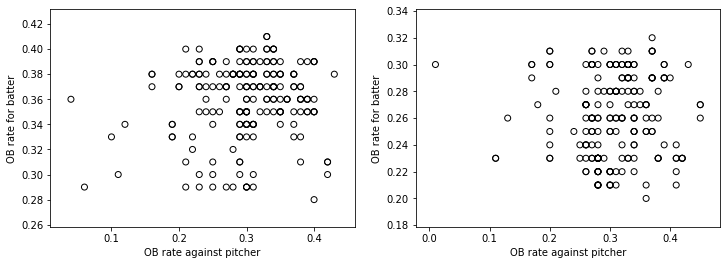

<IPython.core.display.Javascript object>

In [980]:
# Hitter performance with pitcher historical performance

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_b_p_merged["prop_events_nback_bs"], df_b_p_merged["prop_events_nback"],
               facecolors="none",
    edgecolors="black")
ax1.set_xlabel("OB rate against pitcher")
ax1.set_ylabel("OB rate for batter")

ax2.scatter(df_b_p_merged_b2["prop_events_nback_bs"], df_b_p_merged_b2["prop_events_nback"],
               facecolors="none",
    edgecolors="black")
ax2.set_xlabel("OB rate against pitcher")
ax2.set_ylabel("OB rate for batter")


Text(0.5, 1.0, 'Player 1 (overall)')

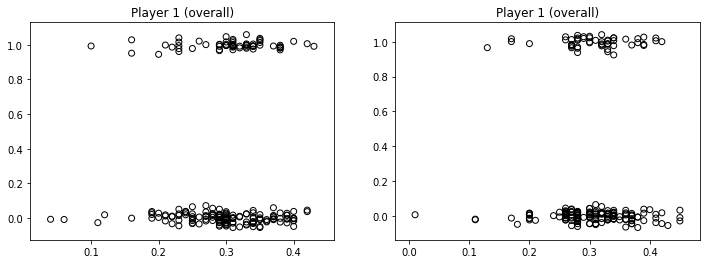

<IPython.core.display.Javascript object>

In [984]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(
    df_b_p_merged["prop_events_nback_bs"],
    df_b_p_merged["event_code"] + np.random.normal(0, 0.025, len(df_b_p_merged)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 1 (overall)")

ax2.scatter(
    df_b_p_merged_b2["prop_events_nback_bs"],
    df_b_p_merged_b2["event_code"] + np.random.normal(0, 0.025, len(df_b_p_merged_b2)),
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("Player 2 (overall)")

In [991]:
# # verify it's not the same data
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# ax1.scatter(
#     df_b_p_merged["prop_events_nback_bs"], df_b_p_merged_b2["prop_events_nback_bs"]
# )

# ax2.scatter(df_b_p_merged["event_code"], df_b_p_merged_b2["event_code"])

<IPython.core.display.Javascript object>

## Logistic regression

### Separate "day of" from "pre-date" data

In [ ]:
df4model_dayof_bpm1 = df_b_p_merged[df_b_p_merged["game_date"] == date_of_interest].copy()
df4model_dayof_bpm1

In [ ]:
df4model_dayof_bpm2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()
df4model_dayof_bpm2

In [939]:
col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]
df4model_b1_lim = df4model_b1.loc[
    df4model_b1["game_date"] < date_of_interest, col4model
].copy()

df4model_b2_lim = df4model_b2.loc[
    df4model_b2["game_date"] < date_of_interest, col4model
].copy()


# df4model_b1_lim = df4model_b1[col4model].copy()
# df4model_b2_lim = df4model_b2[col4model].copy()

<IPython.core.display.Javascript object>

In [940]:
pd.concat([df4model_b1_lim.head(), df4model_b2_lim.head()], axis=1)

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
5,0,R,0.36,0.41,0,R,0.22,0.24
6,0,L,0.37,0.29,1,R,0.22,0.23
7,0,R,0.38,0.41,0,R,0.22,0.24
8,0,R,0.38,0.41,0,R,0.22,0.24
9,0,R,0.39,0.42,0,R,0.23,0.24


<IPython.core.display.Javascript object>

In [941]:
# FUNCTION TO REPLACE CATEGORICAL INPUT
df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

In [1477]:
X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
    df4model_b1_lim, 0.4
)
X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
    df4model_b2_lim, 0.4
)

<IPython.core.display.Javascript object>

In [1478]:
df_b_p_merged.shape

(201, 7)

<IPython.core.display.Javascript object>

In [ ]:
print(X_train_scale_b1.shape, X_test_scale_b1.shape, y_train_b1.shape, y_test_b1.shape)
print(X_train_scale_b2.shape, X_test_scale_b2.shape, y_train_b2.shape, y_test_b2.shape)

In [1480]:
log_reg_p1_wp = LogisticRegression()
log_reg_p1_wp.fit(X_train_scale_p1, y_train_p1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [1481]:
y_pred_p1 = log_reg_p1_wp.predict(X_test_scale_p1)
y_predprob_p1 = log_reg_p1_wp.predict_proba(X_test_scale_p1)[:, 1]

<IPython.core.display.Javascript object>

In [1482]:
df_eval_p1 = pd.DataFrame(
    {"test": y_test_p1, "pred": y_pred_p1, "predprob": y_predprob_p1}
)
df_eval_p1.head()

,test,pred,predprob
40,1,0,0.315222
141,0,0,0.327202
33,0,0,0.296921
91,1,0,0.466917
13,0,0,0.260403


<IPython.core.display.Javascript object>

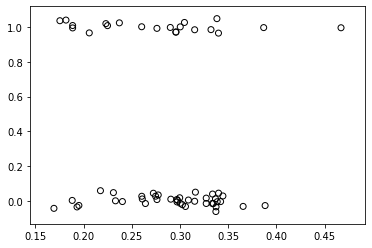

<IPython.core.display.Javascript object>

In [1483]:
f, ax1 = plt.subplots()

#
ax1.scatter(
    df_eval_p1["predprob"],
    df_eval_p1["test"] + np.random.normal(0, 0.025, len(df_eval_p1)),
    facecolors="none",
    edgecolors="black",
)

In [1484]:
log_reg_p1_wp.coef_

array([[-0.28088299,  0.06408509,  0.01514172,  0.20912622, -0.30236944,
        -0.59698024]])

<IPython.core.display.Javascript object>

In [1372]:
# print(
#     "low prob, 0: ", ((df_eval_p1["predprob"] < 0.29) & (df_eval_p1["test"] == 0)).sum()
# )
# print(
#     "low prob, 1: ", ((df_eval_p1["predprob"] < 0.29) & (df_eval_p1["test"] == 1)).sum()
# )
# print(
#     "high prob, 0: ",
#     ((df_eval_p1["predprob"] > 0.29) & (df_eval_p1["test"] == 0)).sum(),
# )
# print(
#     "high prob, 1: ",
#     ((df_eval_p1["predprob"] > 0.29) & (df_eval_p1["test"] == 1)).sum(),
# )

low prob, 0:  16
low prob, 1:  9
high prob, 0:  24
high prob, 1:  12


<IPython.core.display.Javascript object>

In [1011]:
# The number of right-handed pitchers matches the "high probability"
# X_test_p1["p_throws"].sum()

48

<IPython.core.display.Javascript object>

# Add pitcher feature - simple

In [ ]:

# # Reynolds (668804, Bryan Reynolds (PIT))
# pid_of_interest1 = 668804

# # Enter key_mlbam (Leury Garcia, ESPN rank 300)
# pid_of_interest2 = 544725


In [1004]:
df_sc_events_b1.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FC,2019-09-25,87.4,2.7441,5.7888,Jon Lester,668804.0,452657.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
1,SI,2019-09-24,94.8,2.6869,6.0305,Derek Holland,668804.0,502706.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
2,CH,2019-09-24,81.0,2.8359,5.4730,Danny Hultzen,668804.0,543343.0,fielders_choice,hit_into_play_score,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
3,FF,2019-09-24,85.2,-2.5214,5.8412,Kyle Hendricks,668804.0,543294.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
4,CH,2019-09-24,76.7,-2.4278,6.0267,Kyle Hendricks,668804.0,543294.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0


<IPython.core.display.Javascript object>

In [1001]:
[print(i) for i in df_pitching_stats19_wpid.columns]

index
Season
Name
Team
Age
W
L
ERA
WAR
G
GS
CG
ShO
SV
BS
IP
TBF
H
R
ER
HR
BB
IBB
HBP
WP
BK
SO
GB
FB
LD
IFFB
Balls
Strikes
Pitches
RS
IFH
BU
BUH
K/9
BB/9
K/BB
H/9
HR/9
AVG
WHIP
BABIP
LOB_perc
FIP
GB/FB
LD_perc
GB_perc
IFFB_perc
HR/FB
IFH_perc
BUH_perc
Starting
Start-IP
Relieving
Relief-IP
RAR
Dollars
tERA
xFIP
WPA
-WPA
+WPA
RE24
REW
pLI
inLI
gmLI
exLI
Pulls
WPA/LI
Clutch
FB_perc
FBv
SL_perc
SLv
CT_perc
CTv
CB_perc
CBv
CH_perc
CHv
SF_perc
SFv
KN_perc
KNv
XX_perc
PO_perc
wFB
wSL
wCT
wCB
wCH
wSF
wKN
wFB/C
wSL/C
wCT/C
wCB/C
wCH/C
wSF/C
wKN/C
O-Swing_perc
Z-Swing_perc
Swing_perc
O-Contact_perc
Z-Contact_perc
Contact_perc
Zone_perc
F-Strike_perc
SwStr_perc
HLD
SD
MD
ERA-
FIP-
xFIP-
K_perc
BB_perc
SIERA
RS/9
E-F
FA_perc _pfx
FT_perc _pfx
FC_perc _pfx
FS_perc _pfx
FO_perc _pfx
SI_perc _pfx
SL_perc _pfx
CU_perc _pfx
KC_perc _pfx
EP_perc _pfx
CH_perc _pfx
SC_perc _pfx
KN_perc _pfx
UN_perc _pfx
vFA _pfx
vFT _pfx
vFC _pfx
vFS _pfx
vFO _pfx
vSI _pfx
vSL _pfx
vCU _pfx
vKC _pfx
vEP _pfx
vCH _pfx
vSC _

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [1006]:
col4pitch2merge = ["Name", "key_mlbam", "WAR", "FIP", "K/9", "BB/9", "H/9", "HR/9"]

<IPython.core.display.Javascript object>

In [1007]:
df_sc_events_b1_wp = pd.merge(
    df_sc_events_b1,
    df_pitching_stats19_wpid[col4pitch2merge],
    left_on="pitcher",
    right_on="key_mlbam",
)

<IPython.core.display.Javascript object>

In [1016]:
df_sc_events_b1_wp.head(5)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,mlb_played_first,mlb_played_last,Name,key_mlbam_y,WAR,FIP,K/9,BB/9,H/9,HR/9
0,FC,2019-09-25,87.4,2.7441,5.7888,Jon Lester,668804.0,452657.0,field_out,hit_into_play,...,2019.0,2019.0,Jon Lester,452657.0,2.8,4.26,8.65,2.73,10.75,1.36
1,FF,2019-09-13,91.5,2.7389,5.5907,Jon Lester,668804.0,452657.0,strikeout,called_strike,...,2019.0,2019.0,Jon Lester,452657.0,2.8,4.26,8.65,2.73,10.75,1.36
2,CH,2019-09-13,83.4,2.5857,5.7340,Jon Lester,668804.0,452657.0,field_out,hit_into_play,...,2019.0,2019.0,Jon Lester,452657.0,2.8,4.26,8.65,2.73,10.75,1.36
3,FC,2019-09-13,89.0,2.6932,5.6271,Jon Lester,668804.0,452657.0,walk,ball,...,2019.0,2019.0,Jon Lester,452657.0,2.8,4.26,8.65,2.73,10.75,1.36
4,FC,2019-08-17,89.5,2.9043,5.5325,Jon Lester,668804.0,452657.0,strikeout,called_strike,...,2019.0,2019.0,Jon Lester,452657.0,2.8,4.26,8.65,2.73,10.75,1.36


<IPython.core.display.Javascript object>

In [1017]:
df_sc_events_b2_wp = pd.merge(
    df_sc_events_b2,
    df_pitching_stats19_wpid[col4pitch2merge],
    left_on="pitcher",
    right_on="key_mlbam",
)

<IPython.core.display.Javascript object>

In [1018]:
df_sc_events_b2_wp.head(5)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,mlb_played_first,mlb_played_last,Name,key_mlbam_y,WAR,FIP,K/9,BB/9,H/9,HR/9
0,KC,2019-09-25,83.4,-1.4102,5.7922,Shane Bieber,544725.0,669456.0,strikeout,swinging_strike_blocked,...,2013.0,2019.0,Shane Bieber,669456.0,5.6,3.32,10.88,1.68,7.81,1.3
1,SL,2019-09-25,85.6,-1.4502,5.7454,Shane Bieber,544725.0,669456.0,strikeout_double_play,swinging_strike,...,2013.0,2019.0,Shane Bieber,669456.0,5.6,3.32,10.88,1.68,7.81,1.3
2,FF,2019-09-25,94.3,-1.3690,5.8501,Shane Bieber,544725.0,669456.0,home_run,hit_into_play_score,...,2013.0,2019.0,Shane Bieber,669456.0,5.6,3.32,10.88,1.68,7.81,1.3
3,KC,2019-09-04,83.2,-1.3917,5.7539,Shane Bieber,544725.0,669456.0,strikeout,swinging_strike_blocked,...,2013.0,2019.0,Shane Bieber,669456.0,5.6,3.32,10.88,1.68,7.81,1.3
4,KC,2019-09-04,82.5,-1.5268,5.7392,Shane Bieber,544725.0,669456.0,force_out,hit_into_play,...,2013.0,2019.0,Shane Bieber,669456.0,5.6,3.32,10.88,1.68,7.81,1.3


<IPython.core.display.Javascript object>

In [1010]:
def get_df4model_wp(df, n_back_PA, m_size):
    """
    Function for getting summarized DF
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200
    # -------------------------

    # Reset index so that code below works
    df.reset_index(inplace=True)

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak
    df["num_events_sum_nback"] = (
        df["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]
    )

    # Percent of on-base events (overall)
    df["prop_events_nback"] = df["num_events_sum_nback"] / n_back_PA

    # Percent of on-base events against handedness of pitcher
    for i in df.index:
        p_throws = df["p_throws"].iloc[i]  # Get handedness of pitcher
        df_pt_throw = df[df["p_throws"] == p_throws]
        n_pt_events = df_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
        df.loc[i, "num_events_sum_nback_pt"] = n_pt_events
        df.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]

    # Pitcher col
    col_p_4model = ["WAR", "FIP", "K/9", "BB/9", "H/9", "HR/9"]

    df_4model = df[col4model + col_p_4model].copy()
    df_4model_overall = df_4model.loc[:m_size]

    df_meta_w_model_overall = pd.merge(
        df[["game_date", "inning", "outs_when_up", "events", "player_name", "pitcher"]],
        df_4model_overall,
        left_index=True,
        right_index=True,
    )

    return df_meta_w_model_overall

<IPython.core.display.Javascript object>

In [1013]:
df4model_b1_wp = get_df4model_wp(
    df=df_sc_events_b1_wp.copy(), n_back_PA=100, m_size=200
)

<IPython.core.display.Javascript object>

In [1014]:
df4model_b1_wp.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
1,2019-09-13,4.0,2.0,strikeout,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
2,2019-09-13,2.0,1.0,field_out,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
3,2019-09-13,1.0,0.0,walk,Jon Lester,452657.0,1,L,0.27,0.27,2.8,4.26,8.65,2.73,10.75,1.36
4,2019-08-17,5.0,1.0,strikeout,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36


<IPython.core.display.Javascript object>

In [1019]:
df4model_b2_wp = get_df4model_wp(
    df=df_sc_events_b2_wp.copy(), n_back_PA=100, m_size=200
)

<IPython.core.display.Javascript object>

In [1021]:
df4model_b2_wp.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,4.0,1.0,strikeout,Shane Bieber,669456.0,0,R,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
1,2019-09-25,2.0,1.0,strikeout_double_play,Shane Bieber,669456.0,0,R,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
2,2019-09-25,1.0,0.0,home_run,Shane Bieber,669456.0,1,R,0.31,0.24,5.6,3.32,10.88,1.68,7.81,1.3
3,2019-09-04,7.0,2.0,strikeout,Shane Bieber,669456.0,0,R,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
4,2019-09-04,5.0,0.0,force_out,Shane Bieber,669456.0,0,R,0.30,0.25,5.6,3.32,10.88,1.68,7.81,1.3


<IPython.core.display.Javascript object>

## EDA

- Are bad pitchers more likely to allow someone to get on base?

Text(0.5, 0, 'pitcher WAR')

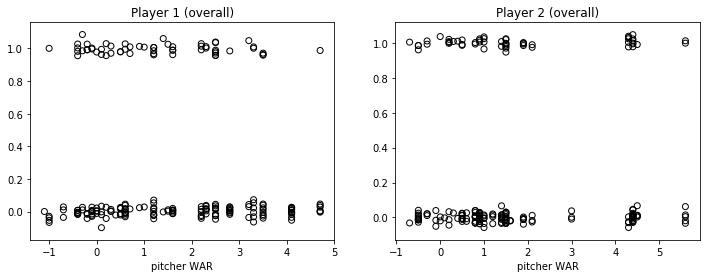

<IPython.core.display.Javascript object>

In [1023]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(
    df4model_b1_wp["WAR"],
    df4model_b1_wp["event_code"] + np.random.normal(0, 0.025, len(df4model_b1)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 1 (overall)")
ax1.set_xlabel("pitcher WAR")

ax2.scatter(
    df4model_b2_wp["WAR"],
    df4model_b2_wp["event_code"] + np.random.normal(0, 0.025, len(df4model_b2)),
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("Player 2 (overall)")
ax2.set_xlabel("pitcher WAR")

## Logistic regression

### Separate "day of" rows

In [1024]:
date_of_interest

"'2019-09-25'"

<IPython.core.display.Javascript object>

In [1058]:
df4model_b1_wp_dayof = df4model_b1_wp[
    df4model_b1_wp["game_date"] == date_of_interest
].copy()
df4model_b1_wp_dayof

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36


<IPython.core.display.Javascript object>

In [1059]:
df4model_b2_wp_dayof = df4model_b2_wp[
    df4model_b2_wp["game_date"] == date_of_interest
].copy()
df4model_b2_wp_dayof

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,4.0,1.0,strikeout,Shane Bieber,669456.0,0,R,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
1,2019-09-25,2.0,1.0,strikeout_double_play,Shane Bieber,669456.0,0,R,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
2,2019-09-25,1.0,0.0,home_run,Shane Bieber,669456.0,1,R,0.31,0.24,5.6,3.32,10.88,1.68,7.81,1.3


<IPython.core.display.Javascript object>

In [1028]:
col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt", 'WAR', 'FIP', 'K/9', 'BB/9', 'H/9', 'HR/9']

df4model_b1_wp_lim = df4model_b1_wp.loc[
    df4model_b1["game_date"] < date_of_interest, col4model
].copy()

df4model_b2_wp_lim = df4model_b2_wp.loc[
    df4model_b2_wp["game_date"] < date_of_interest, col4model
].copy()


<IPython.core.display.Javascript object>

In [1031]:
# FUNCTION TO REPLACE CATEGORICAL INPUT
df4model_b1_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df4model_b2_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

### Split and run model

In [1041]:
X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
    df4model_b1_wp_lim, 0.4
)
X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
    df4model_b2_wp_lim, 0.4
)

<IPython.core.display.Javascript object>

In [1042]:
print(X_train_scale_b1.shape, X_test_scale_b1.shape, y_train_b1.shape, y_test_b1.shape)
print(X_train_scale_b2.shape, X_test_scale_b2.shape, y_train_b2.shape, y_test_b2.shape)

(120, 9) (80, 9) (120,) (80,)
(118, 9) (80, 9) (118,) (80,)


<IPython.core.display.Javascript object>

In [1043]:
log_reg_b1_wps = LogisticRegression()
log_reg_b1_wps.fit(X_train_scale_b1, y_train_b1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [1044]:
y_pred_b1 = log_reg_b1_wps.predict(X_test_scale_b1)
y_predprob_b1 = log_reg_b1_wps.predict_proba(X_test_scale_b1)[:, 1]

<IPython.core.display.Javascript object>

In [1045]:
df_eval_b1 = pd.DataFrame(
    {"test": y_test_b1, "pred": y_pred_b1, "predprob": y_predprob_b1}
)
df_eval_b1.head()

,test,pred,predprob
41,1,0,0.285650
141,0,0,0.289125
34,0,0,0.097618
92,1,0,0.156098
14,0,0,0.123454


<IPython.core.display.Javascript object>

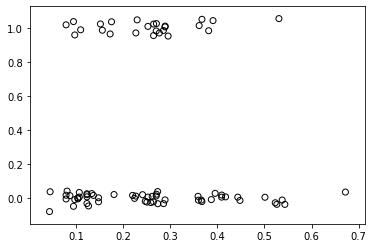

<IPython.core.display.Javascript object>

In [1046]:
f, ax1 = plt.subplots()

ax1.scatter(
    df_eval_b1["predprob"],
    df_eval_b1["test"] + np.random.normal(0, 0.025, len(df_eval_b1)),
    facecolors="none",
    edgecolors="black",
)

In [1047]:
log_reg_b2_wps = LogisticRegression()
log_reg_b2_wps.fit(X_train_scale_b2, y_train_b2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [1048]:
y_pred_b2 = log_reg_b2_wps.predict(X_test_scale_b2)
y_predprob_b2 = log_reg_b2_wps.predict_proba(X_test_scale_b2)[:, 1]

<IPython.core.display.Javascript object>

In [1049]:
df_eval_b2 = pd.DataFrame(
    {"test": y_test_b2, "pred": y_pred_b2, "predprob": y_predprob_b2}
)
df_eval_b2.head()

,test,pred,predprob
34,0,0,0.197808
78,1,0,0.325605
149,0,0,0.237386
40,0,0,0.110332
85,1,0,0.205866


<IPython.core.display.Javascript object>

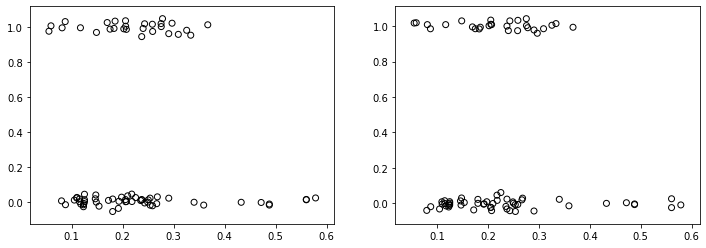

<IPython.core.display.Javascript object>

In [1051]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(
    df_eval_b2["predprob"],
    df_eval_b2["test"] + np.random.normal(0, 0.025, len(df_eval_b2)),
    facecolors="none",
    edgecolors="black",
)

ax2.scatter(
    df_eval_b2["predprob"],
    df_eval_b2["test"] + np.random.normal(0, 0.025, len(df_eval_b2)),
    facecolors="none",
    edgecolors="black",
)

In [1052]:
df4model_b1_wp_lim.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
1,0,0,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
2,0,0,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
3,1,0,0.27,0.27,2.8,4.26,8.65,2.73,10.75,1.36
4,0,0,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
5,0,0,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36


<IPython.core.display.Javascript object>

In [1053]:
df4model_b1_wp.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
1,2019-09-13,4.0,2.0,strikeout,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
2,2019-09-13,2.0,1.0,field_out,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36
3,2019-09-13,1.0,0.0,walk,Jon Lester,452657.0,1,L,0.27,0.27,2.8,4.26,8.65,2.73,10.75,1.36
4,2019-08-17,5.0,1.0,strikeout,Jon Lester,452657.0,0,L,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36


<IPython.core.display.Javascript object>

## Output for new case

In [1071]:
def get_df_ab_vs_startingp(df_day_of):
    # Get up to last 5 at-bats for the input
    df_day_of_last5 = df_day_of.loc[-5:, :]

    # Get starting opposing pitcher
    startingp = df_day_of_last5["pitcher"].iloc[-1]

    # Limit ab to those against that pithcer
    df_day_of_last5_vs_startingp = df_day_of_last5[
        df_day_of_last5["pitcher"] == startingp
    ].copy()

    # replace categorical input
    df_day_of_last5_vs_startingp["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    return df_day_of_last5_vs_startingp

<IPython.core.display.Javascript object>

In [1076]:
df4model_b1_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b1_wp_dayof)
df4model_b1_wp_dayof_sp

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,0,0.26,0.27,2.8,4.26,8.65,2.73,10.75,1.36


<IPython.core.display.Javascript object>

In [1077]:
df4model_b2_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b2_wp_dayof)
df4model_b2_wp_dayof_sp

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9
0,2019-09-25,4.0,1.0,strikeout,Shane Bieber,669456.0,0,1,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
1,2019-09-25,2.0,1.0,strikeout_double_play,Shane Bieber,669456.0,0,1,0.30,0.24,5.6,3.32,10.88,1.68,7.81,1.3
2,2019-09-25,1.0,0.0,home_run,Shane Bieber,669456.0,1,1,0.31,0.24,5.6,3.32,10.88,1.68,7.81,1.3


<IPython.core.display.Javascript object>

In [1079]:
col4model = [
    "event_code",
    "p_throws",
    "prop_events_nback",
    "prop_events_sum_nback_pt",
    "WAR",
    "FIP",
    "K/9",
    "BB/9",
    "H/9",
    "HR/9",
]

df4model_b1_wp_dayof_sp_lim = df4model_b1_wp_dayof_sp.loc[:, col4model].copy()
df4model_b2_wp_dayof_sp_lim = df4model_b2_wp_dayof_sp.loc[:, col4model].copy()

<IPython.core.display.Javascript object>

In [1177]:
def return_series_of_player_prediction_counts(
    df4model_dayof_b1, df4model_dayof_b2, log_reg_b1, log_reg_b2
):
    s_new_case = pd.Series()

    # actual performance
    s_new_case["actual_performance_batterA"] = df4model_dayof_b1.reset_index()[
        "event_code"
    ].sum()
    s_new_case["actual_performance_batterB"] = df4model_dayof_b2.reset_index()[
        "event_code"
    ].sum()

    # ADD VARIANCE - TBD
    s_new_case["pred_var_batterA"] = None
    s_new_case["pred_var_batterB"] = None

    # vs actual pitcher
    s_new_case["pred_vs_gamepitcher_batterA"] = log_reg_b1.predict_proba(
        df4model_dayof_b1.iloc[:, 1:]
    )[:, 1].mean()

    s_new_case["pred_vs_gamepitcher_batterB"] = log_reg_b2.predict_proba(
        df4model_dayof_b2.iloc[:, 1:]
    )[:, 1].mean()

    # Prediction
    if (
        s_new_case["pred_vs_gamepitcher_batterA"]
        > s_new_case["pred_vs_gamepitcher_batterB"]
    ):
        predict_for_day = "A"
    elif (
        s_new_case["pred_vs_gamepitcher_batterA"]
        == s_new_case["pred_vs_gamepitcher_batterB"]
    ):
        predict_for_day = "even"
    else:
        predict_for_day = "B"

    # Actual case
    if (
        s_new_case["actual_performance_batterA"]
        > s_new_case["actual_performance_batterB"]
    ):
        actual_for_day = "A"

    elif (
        s_new_case["actual_performance_batterA"]
        == s_new_case["actual_performance_batterB"]
    ):
        actual_for_day = "even"
    else:
        actual_for_day = "B"

    validation_entries = (
        date_of_interest,
        pid_of_interest1,
        pid_of_interest2,
        predict_for_day,
        actual_for_day,
    )

    return s_new_case, validation_entries

<IPython.core.display.Javascript object>

In [ ]:
# Look at variance of prediction

## VALIDATION with multiple dates


### Easy case

In [1231]:
# Betts and Garcia (668804, 544725)

pid1 = 605141
pid2 = 544725

# (20ish dates)
date_list = [
    "'2019-08-05'",
    "'2019-08-06'",
    "'2019-08-07'",
    "'2019-08-09'",
    "'2019-08-10'",
    "'2019-08-16'",
    "'2019-08-17'",
    "'2019-08-18'",
    "'2019-08-20'",
    "'2019-08-21'",
    "'2019-08-23'",
    "'2019-08-24'",
    "'2019-08-25'",
    "'2019-08-27'",
    "'2019-08-28'",
    "'2019-08-30'",
    "'2019-08-31'",
    "'2019-09-01'",
    "'2019-09-03'",
    "'2019-09-04'",
    "'2019-09-10'",
    "'2019-09-12'",
    "'2019-09-21'",
    "'2019-09-24'",
]


# # (12 dates)
# date_list = [
#     "'2019-08-25'",
#     "'2019-08-27'",
#     "'2019-08-28'",
#     "'2019-08-30'",
#     "'2019-08-31'",
#     "'2019-09-01'",
#     "'2019-09-03'",
#     "'2019-09-04'",
#     "'2019-09-10'",
#     "'2019-09-12'",
#     "'2019-09-21'",
#     "'2019-09-24'",
# ]

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_player1_coef = pd.DataFrame()
df_player2_coef = pd.DataFrame()
df_pred_actual_bydate = pd.DataFrame()
df_pred_actual_bydate_detail = pd.DataFrame()


for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Add pitcher features
    col4pitch2merge = ["Name", "key_mlbam", "WAR", "FIP", "K/9", "BB/9", "H/9", "HR/9"]
    df_sc_events_b1_wp = pd.merge(
        df_sc_events_b1,
        df_pitching_stats19_wpid[col4pitch2merge],
        left_on="pitcher",
        right_on="key_mlbam",
    )

    df_sc_events_b2_wp = pd.merge(
        df_sc_events_b2,
        df_pitching_stats19_wpid[col4pitch2merge],
        left_on="pitcher",
        right_on="key_mlbam",
    )

    # Build model dataframe
    df4model_b1_wp = get_df4model_wp(
        df=df_sc_events_b1_wp.copy(), n_back_PA=100, m_size=200
    )
    df4model_b2_wp = get_df4model_wp(
        df=df_sc_events_b2_wp.copy(), n_back_PA=100, m_size=200
    )

    # Separate "day of" from "pre-date"
    df4model_b1_wp_dayof = df4model_b1_wp[
        df4model_b1_wp["game_date"] == date_of_interest
    ].copy()
    df4model_b2_wp_dayof = df4model_b2_wp[
        df4model_b2_wp["game_date"] == date_of_interest
    ].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
        "WAR",
        "FIP",
        "K/9",
        "BB/9",
        "H/9",
        "HR/9",
    ]

    df4model_b1_wp_lim = df4model_b1_wp.loc[
        df4model_b1_wp["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_wp_lim = df4model_b2_wp.loc[
        df4model_b2_wp["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    # Split data
    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_wp_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_wp_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    #     print("Player 1 coefficients: ", log_reg_b1.coef_)
    #     print(
    #         colored("perc. RHP: " + str(df4model_b1_wp_lim["p_throws"].sum() / 200), "red")
    #     )
    #     print("Player 2 coefficients: ", log_reg_b2.coef_)
    #     print(
    #         colored("perc. RHP: " + str(df4model_b2_wp_lim["p_throws"].sum() / 200), "red")
    #     )

    # Assess day of performance  ---------
    # Get at-bats against first pitcher
    df4model_b1_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b1_wp_dayof)
    df4model_b2_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b2_wp_dayof)

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
        "WAR",
        "FIP",
        "K/9",
        "BB/9",
        "H/9",
        "HR/9",
    ]

    df4model_b1_wp_dayof_sp_lim = df4model_b1_wp_dayof_sp.loc[:, col4model].copy()
    df4model_b2_wp_dayof_sp_lim = df4model_b2_wp_dayof_sp.loc[:, col4model].copy()

    # Return series of player prediction counts

    df_pred_actual, val_entries = return_series_of_player_prediction_counts(
        df4model_b1_wp_dayof_sp_lim,
        df4model_b2_wp_dayof_sp_lim,
        log_reg_b1_wps,
        log_reg_b2_wps,
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    df_pred_actual_bydate_detail[colname] = df_pred_actual

    # Coefficients
    colname = "PlayerA_" + str(date_of_interest).strip("'")
    df_player1_coef[colname] = log_reg_b1.coef_[0]
    df_player1_coef.index = df4model_b1_wp_lim.columns[1:]
    colname = "PlayerB_" + str(date_of_interest).strip("'")
    df_player2_coef[colname] = log_reg_b2.coef_[0]
    df_player2_coef.index = df4model_b2_wp_lim.columns[1:]

    if date_of_interest == date_list[-1]:
        print("done getting dates")

'2019-08-05'
'2019-08-06'
'2019-08-07'
'2019-08-09'
'2019-08-10'
'2019-08-16'
'2019-08-17'
'2019-08-18'
'2019-08-20'
'2019-08-21'
'2019-08-23'
'2019-08-24'
'2019-08-25'
'2019-08-27'
'2019-08-28'
'2019-08-30'
'2019-08-31'
'2019-09-01'
'2019-09-03'
'2019-09-04'
'2019-09-10'
'2019-09-12'
'2019-09-21'
'2019-09-24'
done getting dates


<IPython.core.display.Javascript object>

In [1232]:
df_pred_actual_bydate_detail

,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,A_vs_B_2019-08-18,A_vs_B_2019-08-20,A_vs_B_2019-08-21,...,A_vs_B_2019-08-28,A_vs_B_2019-08-30,A_vs_B_2019-08-31,A_vs_B_2019-09-01,A_vs_B_2019-09-03,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-12,A_vs_B_2019-09-21,A_vs_B_2019-09-24
actual_performance_batterA,1,1,2,2,1,1,2,1,1,1,...,1,2,2,1,0,3,0,1,1,0
actual_performance_batterB,0,0,0,1,0,1,1,0,1,2,...,1,0,1,0,0,1,1,0,1,1
pred_var_batterA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
pred_var_batterB,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
pred_vs_gamepitcher_batterA,0.00979079,0.0035043,0.0255779,0.00996721,0.00116124,0.0114099,0.0044869,0.0099223,0.000947715,0.0042905,...,0.0167007,0.0080758,0.011601,0.0011516,0.00655838,0.00109063,0.00350085,0.0165423,0.000911834,0.0204884
pred_vs_gamepitcher_batterB,0.000901451,0.00160232,0.000911455,0.00242629,0.000861417,0.00103315,0.00104088,0.00116427,0.00171282,0.00169803,...,0.00172662,0.00138525,0.00140436,0.00129422,0.00190223,0.00249377,0.000773826,0.000688593,0.000898512,0.00196865


<IPython.core.display.Javascript object>

In [1233]:
df_pred_actual_bydate

,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,A_vs_B_2019-08-18,A_vs_B_2019-08-20,A_vs_B_2019-08-21,...,A_vs_B_2019-08-28,A_vs_B_2019-08-30,A_vs_B_2019-08-31,A_vs_B_2019-09-01,A_vs_B_2019-09-03,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-12,A_vs_B_2019-09-21,A_vs_B_2019-09-24
game_date,'2019-08-05','2019-08-06','2019-08-07','2019-08-09','2019-08-10','2019-08-16','2019-08-17','2019-08-18','2019-08-20','2019-08-21',...,'2019-08-28','2019-08-30','2019-08-31','2019-09-01','2019-09-03','2019-09-04','2019-09-10','2019-09-12','2019-09-21','2019-09-24'
key_batterA,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804,...,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,...,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,A,A,A,A,A,A,A,A,B,A,...,A,A,A,B,A,B,A,A,A,A
actual,A,A,A,A,A,even,A,A,even,B,...,even,A,A,A,even,A,B,A,even,B


<IPython.core.display.Javascript object>

In [1234]:
df_player1_coef

,PlayerA_2019-08-05,PlayerA_2019-08-06,PlayerA_2019-08-07,PlayerA_2019-08-09,PlayerA_2019-08-10,PlayerA_2019-08-16,PlayerA_2019-08-17,PlayerA_2019-08-18,PlayerA_2019-08-20,PlayerA_2019-08-21,...,PlayerA_2019-08-28,PlayerA_2019-08-30,PlayerA_2019-08-31,PlayerA_2019-09-01,PlayerA_2019-09-03,PlayerA_2019-09-04,PlayerA_2019-09-10,PlayerA_2019-09-12,PlayerA_2019-09-21,PlayerA_2019-09-24
p_throws,0.151500,0.083363,0.317408,0.450145,0.764716,-0.112756,-0.028536,-0.327588,-0.408769,-0.509686,...,-0.288767,-0.246023,-0.537094,-0.311087,-0.551889,-0.606954,0.016958,-0.246442,-0.016200,-0.156639
prop_events_nback,0.111550,-0.000232,0.269909,0.222501,0.328365,-0.072402,0.064005,-0.464709,-0.137014,-0.030761,...,-0.059950,-0.224971,-0.270906,-0.007830,-0.046809,0.301403,0.413694,0.364174,0.252731,0.581519
prop_events_sum_nback_pt,-0.088036,0.236166,-0.113138,-0.454966,-0.594090,-0.216223,-0.103758,-0.219670,-0.095350,0.162668,...,-0.101329,0.017909,-0.205276,0.131277,0.213977,0.208667,-0.016881,-0.056614,-0.184640,-0.452475
WAR,0.002715,-0.133825,-0.027082,0.561632,0.214071,-0.177572,0.172304,-0.309229,-0.839500,-0.511570,...,-0.276942,-0.211370,-0.528318,-0.550445,-0.207859,0.021108,0.282297,0.008411,0.087836,-0.179335
FIP,-0.361379,-0.475387,-0.116262,-0.017919,0.043510,0.133407,0.140570,0.060465,-0.030773,0.414670,...,0.198182,0.397292,-0.067362,0.286577,0.113759,0.162402,-0.033034,-0.149713,-0.196715,-0.660921
K/9,-0.058741,-0.066310,-0.072562,-0.226234,-0.294485,0.738282,0.407910,0.701705,0.655843,0.687638,...,0.675136,0.597569,0.421885,0.481154,0.618029,0.051844,-0.577392,-0.428573,0.103482,-0.261312
BB/9,0.462258,0.297799,0.412484,0.279004,0.532365,0.391083,0.386439,0.329603,0.045029,0.125307,...,-0.255268,0.206332,-0.406817,-0.182075,-0.042269,-0.025482,-0.003063,-0.097484,-0.056370,0.055584
H/9,-0.173032,-0.049079,0.031971,0.011440,-0.177470,0.011856,0.009735,-0.043453,-0.355242,-0.463016,...,0.104898,-0.093373,-0.230267,-0.414114,-0.081545,-0.236414,0.007069,-0.087060,0.417835,0.071181
HR/9,0.257105,0.150465,-0.255438,0.043391,-0.043991,0.164919,0.162198,0.209124,0.128830,0.242883,...,0.154080,-0.171244,0.340673,0.086921,0.258677,0.176369,-0.269030,-0.012638,-0.197203,0.198290


<IPython.core.display.Javascript object>

In [1235]:
df_player2_coef

,PlayerB_2019-08-05,PlayerB_2019-08-06,PlayerB_2019-08-07,PlayerB_2019-08-09,PlayerB_2019-08-10,PlayerB_2019-08-16,PlayerB_2019-08-17,PlayerB_2019-08-18,PlayerB_2019-08-20,PlayerB_2019-08-21,...,PlayerB_2019-08-28,PlayerB_2019-08-30,PlayerB_2019-08-31,PlayerB_2019-09-01,PlayerB_2019-09-03,PlayerB_2019-09-04,PlayerB_2019-09-10,PlayerB_2019-09-12,PlayerB_2019-09-21,PlayerB_2019-09-24
p_throws,-0.159734,0.168425,0.053448,-0.302823,-0.190940,-0.248984,-0.293359,-0.265918,-0.311312,-0.367694,...,-0.631299,-0.591448,-0.477829,-0.195099,0.148615,0.355802,0.287138,0.287866,-0.470792,-0.515752
prop_events_nback,0.352738,0.534147,0.319624,0.446627,-0.155405,0.878005,0.622981,0.476453,0.386934,0.411467,...,0.301367,0.430914,0.659678,0.347793,0.249765,0.474150,0.485921,0.733203,0.383133,0.707092
prop_events_sum_nback_pt,-0.216620,0.331290,0.157505,-0.032668,-0.159462,0.094955,0.203337,-0.024123,-0.349857,-0.136359,...,-0.526610,-0.391056,-0.722762,-0.372282,0.130661,-0.425447,-0.142086,-0.659062,-0.100198,-0.349897
WAR,0.156948,0.007244,-0.011537,-0.109462,-0.037778,0.144758,0.229503,-0.082944,-0.223099,0.109918,...,0.618154,0.509239,0.161554,0.739938,0.284367,0.282187,0.055079,-0.239467,-0.232203,-0.349272
FIP,-0.131659,-0.194384,-0.257982,-0.444602,-0.128927,-0.394380,-0.080961,-0.335932,-0.477198,-0.531311,...,-0.237494,0.008508,-0.371945,-0.078956,-0.466624,-0.022848,-0.315983,-0.319783,-0.135380,-0.614483
K/9,-0.228874,-0.097084,-0.268433,0.024653,0.061700,-0.412154,-0.215582,-0.118653,-0.348529,-0.167405,...,-0.210464,-0.203400,-0.325037,-0.324914,-0.101731,0.137892,-0.067129,0.079845,-0.016823,-0.155589
BB/9,0.367046,0.069881,0.139056,0.079165,-0.043112,0.355730,0.232510,0.131986,0.060924,0.149797,...,0.212321,0.503487,0.139587,0.299229,0.174125,0.255161,0.117162,-0.024788,0.192903,0.280813
H/9,-0.048571,0.294537,-0.049966,-0.132286,0.355480,0.187403,-0.047102,-0.255306,-0.348814,-0.141317,...,-0.240663,-0.381920,0.018177,-0.110162,-0.162543,0.225578,0.049232,-0.332886,-0.118870,-0.120126
HR/9,0.005521,0.290114,0.260040,0.182712,0.056311,0.488232,0.529779,0.218419,-0.103288,0.317852,...,0.400476,0.005505,0.119245,0.357333,0.227969,0.274829,0.421483,0.270006,-0.081885,0.264149


<IPython.core.display.Javascript object>

In [1236]:
pred_right = 0
pred_wrong = 0
pred_halfwrong = 0

for i in range(df_pred_actual_bydate.shape[1]):
    pred = df_pred_actual_bydate.loc["prediction", :].iloc[i]
    actual = df_pred_actual_bydate.loc["actual", :].iloc[i]
    # print(pred, actual)
    if pred == actual:
        pred_right += 1
    elif (pred != actual) and ("even" in pred or "even" in actual):
        pred_halfwrong += 1
    else:
        pred_wrong += 1

print(
    "correct: ",
    str(pred_right),
    "half right: ",
    str(pred_halfwrong),
    "wrong: ",
    str(pred_wrong),
)

correct:  12 half right:  6 wrong:  6


<IPython.core.display.Javascript object>

### Medium case

In [1240]:
df_sc_events_b2.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FF,2019-08-02,77.9,-2.2730,5.9418,Roman Quinn,544725.0,596451.0,single,hit_into_play_no_out,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
1,FF,2019-08-02,94.2,-2.7468,5.6427,Zach Eflin,544725.0,621107.0,field_out,hit_into_play,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
2,FF,2019-08-02,89.5,-0.4280,6.2591,Blake Parker,544725.0,453284.0,field_out,hit_into_play,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
3,FF,2019-08-02,96.8,-2.1726,6.3117,Nick Pivetta,544725.0,601713.0,strikeout,foul_tip,...,Strategic,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
4,KC,2019-08-02,71.8,3.3912,5.2599,Jason Vargas,544725.0,450306.0,strikeout,swinging_strike,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0


<IPython.core.display.Javascript object>

In [1238]:
df4model_b2_wp_dayof.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,WAR,FIP,K/9,BB/9,H/9,HR/9


<IPython.core.display.Javascript object>

In [1241]:
# Reynolds and Garcia (668804, 544725)
# Bryan Reynolds (PIT)

pid1 = 668804
pid2 = 544725

# (35 dates)
date_list = [
    "'2019-08-02'",
    "'2019-08-03'",
    "'2019-08-04'",
    "'2019-08-05'",
    "'2019-08-06'",
    "'2019-08-07'",
    "'2019-08-09'",
    "'2019-08-10'",
    "'2019-08-16'",
    "'2019-08-17'",
    "'2019-08-18'",
    "'2019-08-19'",
    "'2019-08-20'",
    "'2019-08-21'",
    "'2019-08-22'",
    "'2019-08-23'",
    "'2019-08-24'",
    "'2019-08-25'",
    "'2019-08-27'",
    "'2019-08-28'",
    "'2019-08-29'",
    "'2019-08-30'",
    "'2019-08-31'",
    "'2019-09-01'",
    "'2019-09-03'",
    "'2019-09-04'",
    "'2019-09-10'",
    "'2019-09-11'",
    "'2019-09-12'",
    "'2019-09-13'",
    "'2019-09-18'",
    "'2019-09-21'",
    "'2019-09-22'",
    "'2019-09-24'",
    "'2019-09-25'",
]

# date_list = [
#  ""'2019-09-04'",
#  ""'2019-09-10'",
# ]

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_player1_coef = pd.DataFrame()
df_player2_coef = pd.DataFrame()
df_pred_actual_bydate = pd.DataFrame()
df_pred_actual_bydate_detail = pd.DataFrame()


for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Add pitcher features
    df_sc_events_b1_wp = pd.merge(
        df_sc_events_b1,
        df_pitching_stats19_wpid[col4pitch2merge],
        left_on="pitcher",
        right_on="key_mlbam",
    )

    df_sc_events_b2_wp = pd.merge(
        df_sc_events_b2,
        df_pitching_stats19_wpid[col4pitch2merge],
        left_on="pitcher",
        right_on="key_mlbam",
    )

    # Build model dataframe
    df4model_b1_wp = get_df4model_wp(
        df=df_sc_events_b1_wp.copy(), n_back_PA=100, m_size=200
    )
    df4model_b2_wp = get_df4model_wp(
        df=df_sc_events_b2_wp.copy(), n_back_PA=100, m_size=200
    )

    # Separate "day of" from "pre-date"
    df4model_b1_wp_dayof = df4model_b1_wp[
        df4model_b1_wp["game_date"] == date_of_interest
    ].copy()
    df4model_b2_wp_dayof = df4model_b2_wp[
        df4model_b2_wp["game_date"] == date_of_interest
    ].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
        "WAR",
        "FIP",
        "K/9",
        "BB/9",
        "H/9",
        "HR/9",
    ]

    df4model_b1_wp_lim = df4model_b1_wp.loc[
        df4model_b1_wp["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_wp_lim = df4model_b2_wp.loc[
        df4model_b2_wp["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    # Split data
    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_wp_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_wp_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    #     print("Player 1 coefficients: ", log_reg_b1.coef_)
    #     print(
    #         colored("perc. RHP: " + str(df4model_b1_wp_lim["p_throws"].sum() / 200), "red")
    #     )
    #     print("Player 2 coefficients: ", log_reg_b2.coef_)
    #     print(
    #         colored("perc. RHP: " + str(df4model_b2_wp_lim["p_throws"].sum() / 200), "red")
    #     )

    # Assess day of performance  ---------
    # Get at-bats against first pitcher
    df4model_b1_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b1_wp_dayof)
    df4model_b2_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b2_wp_dayof)

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
        "WAR",
        "FIP",
        "K/9",
        "BB/9",
        "H/9",
        "HR/9",
    ]

    df4model_b1_wp_dayof_sp_lim = df4model_b1_wp_dayof_sp.loc[:, col4model].copy()
    df4model_b2_wp_dayof_sp_lim = df4model_b2_wp_dayof_sp.loc[:, col4model].copy()

    # Return series of player prediction counts

    df_pred_actual, val_entries = return_series_of_player_prediction_counts(
        df4model_b1_wp_dayof_sp_lim,
        df4model_b2_wp_dayof_sp_lim,
        log_reg_b1_wps,
        log_reg_b2_wps,
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    df_pred_actual_bydate_detail[colname] = df_pred_actual

    # Coefficients
    colname = "PlayerA_" + str(date_of_interest).strip("'")
    df_player1_coef[colname] = log_reg_b1.coef_[0]
    df_player1_coef.index = df4model_b1_wp_lim.columns[1:]
    colname = "PlayerB_" + str(date_of_interest).strip("'")
    df_player2_coef[colname] = log_reg_b2.coef_[0]
    df_player2_coef.index = df4model_b2_wp_lim.columns[1:]

    if date_of_interest == date_list[-1]:
        print("done getting dates")

'2019-08-02'
'2019-08-03'
'2019-08-04'
'2019-08-05'
'2019-08-06'
'2019-08-07'
'2019-08-09'
'2019-08-10'
'2019-08-16'
'2019-08-17'
'2019-08-18'
'2019-08-19'
'2019-08-20'
'2019-08-21'
'2019-08-22'
'2019-08-23'
'2019-08-24'
'2019-08-25'
'2019-08-27'
'2019-08-28'
'2019-08-29'
'2019-08-30'
'2019-08-31'
'2019-09-01'
'2019-09-03'
'2019-09-04'
'2019-09-10'
'2019-09-11'
'2019-09-12'
'2019-09-13'
'2019-09-18'
'2019-09-21'
'2019-09-22'
'2019-09-24'
'2019-09-25'
done getting dates


<IPython.core.display.Javascript object>

In [1242]:
df_pred_actual_bydate_detail

,A_vs_B_2019-08-02,A_vs_B_2019-08-03,A_vs_B_2019-08-04,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,...,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-13,A_vs_B_2019-09-18,A_vs_B_2019-09-21,A_vs_B_2019-09-22,A_vs_B_2019-09-24,A_vs_B_2019-09-25
actual_performance_batterA,1,3,1,1,1,0,0,1,0,0,...,1,0,0,1,1,1,0,0,0,0
actual_performance_batterB,1,1,1,0,0,0,1,0,1,1,...,1,1,1,0,1,2,1,0,1,1
pred_var_batterA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
pred_var_batterB,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
pred_vs_gamepitcher_batterA,0.00273699,0.00181035,0.000846609,0.00265184,0.00512924,0.00108123,0.00803519,0.00311673,0.0018005,0.00148638,...,0.0149369,0.0130708,0.0048659,0.00729143,0.00148067,0.0168389,0.0103435,0.000746993,0.00181938,0.00147439
pred_vs_gamepitcher_batterB,0.00181061,0.00137152,0.000530415,0.000901451,0.00160232,0.000911455,0.00242629,0.000861417,0.00103315,0.00104088,...,0.00249377,0.000773826,0.000746757,0.000688593,0.000937641,0.00173356,0.000898512,0.000191517,0.00196865,0.00258159


<IPython.core.display.Javascript object>

In [1243]:
df_pred_actual_bydate

,A_vs_B_2019-08-02,A_vs_B_2019-08-03,A_vs_B_2019-08-04,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,...,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-13,A_vs_B_2019-09-18,A_vs_B_2019-09-21,A_vs_B_2019-09-22,A_vs_B_2019-09-24,A_vs_B_2019-09-25
game_date,'2019-08-02','2019-08-03','2019-08-04','2019-08-05','2019-08-06','2019-08-07','2019-08-09','2019-08-10','2019-08-16','2019-08-17',...,'2019-09-04','2019-09-10','2019-09-11','2019-09-12','2019-09-13','2019-09-18','2019-09-21','2019-09-22','2019-09-24','2019-09-25'
key_batterA,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804,...,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,...,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,A,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,B,B
actual,even,A,even,A,A,even,B,A,B,B,...,even,B,B,A,even,B,B,even,B,B


<IPython.core.display.Javascript object>

In [1250]:
# Predicting rare
#df_pred_actual_bydate.loc["prediction", :]=='A'.sum()

29

<IPython.core.display.Javascript object>

In [1244]:
df_pred_actual_bydate.shape[1]


35

<IPython.core.display.Javascript object>

In [1245]:
pred_right = 0
pred_wrong = 0
pred_halfwrong = 0

for i in range(df_pred_actual_bydate.shape[1]):
    pred = df_pred_actual_bydate.loc["prediction", :].iloc[i]
    actual = df_pred_actual_bydate.loc["actual", :].iloc[i]
    # print(pred, actual)
    if pred == actual:
        pred_right += 1
    elif (pred != actual) and ("even" in pred or "even" in actual):
        pred_halfwrong += 1
    else:
        pred_wrong += 1

print(
    "correct: ",
    str(pred_right),
    "half right: ",
    str(pred_halfwrong),
    "wrong: ",
    str(pred_wrong),
)

correct:  16 half right:  10 wrong:  9


<IPython.core.display.Javascript object>

In [1201]:
df_player1_coef

,PlayerA_2019-09-04,PlayerA_2019-09-10,PlayerA_2019-09-11,PlayerA_2019-09-12,PlayerA_2019-09-13,PlayerA_2019-09-18,PlayerA_2019-09-21,PlayerA_2019-09-22,PlayerA_2019-09-24,PlayerA_2019-09-25
p_throws,-0.365981,-0.323070,-0.497995,-0.519436,0.171209,0.777420,0.302285,0.055297,-0.220867,0.230064
prop_events_nback,-0.053420,-0.182604,-0.346862,-0.015246,-0.090830,0.558781,0.378422,0.458968,-0.236757,0.234799
prop_events_sum_nback_pt,0.787819,0.515565,0.722308,0.664903,-0.261237,-0.584180,-0.123107,0.077888,0.644911,-0.354377
WAR,-0.232452,-0.014455,-0.247686,-0.184370,-0.209025,-0.092310,-0.116095,-0.345195,-0.028783,-0.374700
FIP,-0.125515,0.010853,-0.034288,0.003202,-0.467079,-0.115260,0.063426,-0.318797,-0.269196,-0.087870
K/9,-0.087176,-0.230112,-0.271948,-0.526276,-0.348999,-0.421589,-0.489309,-0.478041,-0.102148,-0.431244
BB/9,0.051061,0.122538,0.046151,-0.164391,-0.054196,-0.096374,0.112876,0.017315,0.554859,0.042280
H/9,-0.173436,-0.118706,-0.112653,-0.159503,0.064377,-0.316046,0.206915,-0.171609,0.280136,-0.065670
HR/9,-0.047004,0.106005,-0.054546,0.149846,0.370011,-0.058479,0.037250,0.110000,0.015498,0.286699


<IPython.core.display.Javascript object>

In [1132]:
df_player2_coef

,PlayerB2019-09-04,PlayerB2019-09-10,PlayerB2019-09-11,PlayerB2019-09-12,PlayerB2019-09-13,PlayerB2019-09-18,PlayerB2019-09-21,PlayerB2019-09-22,PlayerB2019-09-24,PlayerB2019-09-25
p_throws,0.016012,-0.169170,-0.193373,-0.329698,-0.219995,-0.609336,-0.455195,-0.198674,-0.287066,-0.320266
prop_events_nback,0.385106,0.333039,0.616754,0.563476,0.657780,0.625406,0.583849,0.397379,0.396763,0.611094
prop_events_sum_nback_pt,0.298884,0.221257,0.003435,0.028827,0.119846,-0.467526,-0.401480,-0.081128,-0.032474,-0.240990
WAR,-0.404729,0.103217,-0.279202,-0.127190,-0.073354,-0.005209,0.344809,0.243362,0.034394,0.150582
FIP,-0.307526,-0.163972,-0.359217,-0.294098,-0.124040,0.220427,-0.029774,0.060117,0.072176,-0.086835
K/9,0.058419,0.109998,-0.026399,-0.023241,0.115055,-0.322397,-0.501076,0.065777,-0.018289,-0.194177
BB/9,0.013261,0.090301,0.082877,0.233465,-0.143520,-0.342470,0.112377,-0.027872,0.031986,-0.178473
H/9,-0.243360,-0.070899,-0.394628,-0.000556,-0.077662,-0.543503,-0.171467,0.244472,-0.107250,-0.355942
HR/9,0.291703,0.338105,0.348276,-0.050907,0.317906,0.313618,0.303975,0.208051,-0.024049,0.188140


<IPython.core.display.Javascript object>

In [1139]:
df_sc_events_b1_test1["p_throws"]

0    L
1    R
2    R
3    R
4    R
5    R
6    R
7    R
8    R
9    R
Name: p_throws, dtype: object

<IPython.core.display.Javascript object>

In [1134]:
# Input batters, date
df_sc_events_b1_test1 = get_sc_batter_df(pid1, "'2019-09-12'", 10)
df_sc_events_b1_test1

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SL,2019-09-12,88.0,1.7842,6.4511,Andrew Suarez,668804.0,605498.0,strikeout,swinging_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
1,FT,2019-09-12,92.8,-2.9275,5.9333,Jeff Samardzija,668804.0,502188.0,fielders_choice_out,hit_into_play,...,Infield shift,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
2,SL,2019-09-12,85.9,-3.0655,6.0450,Jeff Samardzija,668804.0,502188.0,strikeout,called_strike,...,Infield shift,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
3,FF,2019-09-12,90.0,-3.0280,5.9273,Jeff Samardzija,668804.0,502188.0,single,hit_into_play_no_out,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
4,CU,2019-09-11,81.5,-2.7457,5.7236,Kyle Barraclough,668804.0,607457.0,strikeout,swinging_strike_blocked,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
5,CU,2019-09-11,84.4,-2.3998,5.9435,Sam Coonrod,668804.0,656322.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
6,CH,2019-09-11,84.9,-2.2438,5.4235,Logan Webb,668804.0,657277.0,strikeout,swinging_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
7,SL,2019-09-11,82.6,-1.9272,5.4782,Logan Webb,668804.0,657277.0,strikeout,swinging_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
8,FT,2019-09-11,92.8,-1.9919,5.5667,Logan Webb,668804.0,657277.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
9,None,2019-09-10,NaN,NaN,NaN,Sam Coonrod,668804.0,656322.0,single,hit_into_play_no_out,...,None,None,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0


<IPython.core.display.Javascript object>

In [1136]:
df_sc_events_b1_test2 = get_sc_batter_df(pid1, "'2019-09-13'", 10)
df_sc_events_b1_test2

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FF,2019-09-13,93.6,1.5137,6.2251,Brad Wieck,668804.0,623364.0,strikeout,called_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
1,FF,2019-09-13,91.5,2.7389,5.5907,Jon Lester,668804.0,452657.0,strikeout,called_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
2,CH,2019-09-13,83.4,2.5857,5.7340,Jon Lester,668804.0,452657.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
3,FC,2019-09-13,89.0,2.6932,5.6271,Jon Lester,668804.0,452657.0,walk,ball,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
4,SL,2019-09-12,88.0,1.7842,6.4511,Andrew Suarez,668804.0,605498.0,strikeout,swinging_strike,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
5,FT,2019-09-12,92.8,-2.9275,5.9333,Jeff Samardzija,668804.0,502188.0,fielders_choice_out,hit_into_play,...,Infield shift,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
6,SL,2019-09-12,85.9,-3.0655,6.0450,Jeff Samardzija,668804.0,502188.0,strikeout,called_strike,...,Infield shift,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
7,FF,2019-09-12,90.0,-3.0280,5.9273,Jeff Samardzija,668804.0,502188.0,single,hit_into_play_no_out,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
8,CU,2019-09-11,81.5,-2.7457,5.7236,Kyle Barraclough,668804.0,607457.0,strikeout,swinging_strike_blocked,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0
9,CU,2019-09-11,84.4,-2.3998,5.9435,Sam Coonrod,668804.0,656322.0,field_out,hit_into_play,...,Standard,Standard,reynolds,bryan,668804,reynb001,reynobr01,19326,2019.0,2019.0


<IPython.core.display.Javascript object>

### Hard case



In [1253]:
# Santander and Garcia (668804, 544725)

pid1 = 623993
pid2 = 544725

# (35 dates)
date_list = [
    "'2019-08-02'",
    "'2019-08-03'",
    "'2019-08-04'",
    "'2019-08-05'",
    "'2019-08-06'",
    "'2019-08-07'",
    "'2019-08-09'",
    "'2019-08-10'",
    "'2019-08-16'",
    "'2019-08-17'",
    "'2019-08-18'",
    "'2019-08-19'",
    "'2019-08-20'",
    "'2019-08-21'",
    "'2019-08-22'",
    "'2019-08-23'",
    "'2019-08-24'",
    "'2019-08-25'",
    "'2019-08-27'",
    "'2019-08-28'",
    "'2019-08-30'",
    "'2019-08-31'",
    "'2019-09-01'",
    "'2019-09-02'",
    "'2019-09-03'",
    "'2019-09-10'",
    "'2019-09-11'",
    "'2019-09-12'",
    "'2019-09-16'",
    "'2019-09-18'",
    "'2019-09-21'",
]

# date_list = [
#  """'2019-09-04'",
#  """'2019-09-10'",
# ]

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_player1_coef = pd.DataFrame()
df_player2_coef = pd.DataFrame()
df_pred_actual_bydate = pd.DataFrame()
df_pred_actual_bydate_detail = pd.DataFrame()


for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Add pitcher features
    df_sc_events_b1_wp = pd.merge(
        df_sc_events_b1,
        df_pitching_stats19_wpid[col4pitch2merge],
        left_on="pitcher",
        right_on="key_mlbam",
    )

    df_sc_events_b2_wp = pd.merge(
        df_sc_events_b2,
        df_pitching_stats19_wpid[col4pitch2merge],
        left_on="pitcher",
        right_on="key_mlbam",
    )

    # Build model dataframe
    df4model_b1_wp = get_df4model_wp(
        df=df_sc_events_b1_wp.copy(), n_back_PA=100, m_size=200
    )
    df4model_b2_wp = get_df4model_wp(
        df=df_sc_events_b2_wp.copy(), n_back_PA=100, m_size=200
    )

    # Separate "day of" from "pre-date"
    df4model_b1_wp_dayof = df4model_b1_wp[
        df4model_b1_wp["game_date"] == date_of_interest
    ].copy()
    df4model_b2_wp_dayof = df4model_b2_wp[
        df4model_b2_wp["game_date"] == date_of_interest
    ].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
        "WAR",
        "FIP",
        "K/9",
        "BB/9",
        "H/9",
        "HR/9",
    ]

    df4model_b1_wp_lim = df4model_b1_wp.loc[
        df4model_b1_wp["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_wp_lim = df4model_b2_wp.loc[
        df4model_b2_wp["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_wp_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    # Split data
    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_wp_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_wp_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    #     print("Player 1 coefficients: ", log_reg_b1.coef_)
    #     print(
    #         colored("perc. RHP: " + str(df4model_b1_wp_lim["p_throws"].sum() / 200), "red")
    #     )
    #     print("Player 2 coefficients: ", log_reg_b2.coef_)
    #     print(
    #         colored("perc. RHP: " + str(df4model_b2_wp_lim["p_throws"].sum() / 200), "red")
    #     )

    # Assess day of performance  ---------
    # Get at-bats against first pitcher
    df4model_b1_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b1_wp_dayof)
    df4model_b2_wp_dayof_sp = get_df_ab_vs_startingp(df4model_b2_wp_dayof)

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
        "WAR",
        "FIP",
        "K/9",
        "BB/9",
        "H/9",
        "HR/9",
    ]

    df4model_b1_wp_dayof_sp_lim = df4model_b1_wp_dayof_sp.loc[:, col4model].copy()
    df4model_b2_wp_dayof_sp_lim = df4model_b2_wp_dayof_sp.loc[:, col4model].copy()

    # Return series of player prediction counts

    df_pred_actual, val_entries = return_series_of_player_prediction_counts(
        df4model_b1_wp_dayof_sp_lim,
        df4model_b2_wp_dayof_sp_lim,
        log_reg_b1_wps,
        log_reg_b2_wps,
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    df_pred_actual_bydate_detail[colname] = df_pred_actual

    # Coefficients
    colname = "PlayerA_" + str(date_of_interest).strip("'")
    df_player1_coef[colname] = log_reg_b1.coef_[0]
    df_player1_coef.index = df4model_b1_wp_lim.columns[1:]
    colname = "PlayerB_" + str(date_of_interest).strip("'")
    df_player2_coef[colname] = log_reg_b2.coef_[0]
    df_player2_coef.index = df4model_b2_wp_lim.columns[1:]

    if date_of_interest == date_list[-1]:
        print("done getting dates")

'2019-08-02'
'2019-08-03'
'2019-08-04'
'2019-08-05'
'2019-08-06'
'2019-08-07'
'2019-08-09'
'2019-08-10'
'2019-08-16'
'2019-08-17'
'2019-08-18'
'2019-08-19'
'2019-08-20'
'2019-08-21'
'2019-08-22'
'2019-08-23'
'2019-08-24'
'2019-08-25'
'2019-08-27'
'2019-08-28'
'2019-08-30'
'2019-08-31'
'2019-09-01'
'2019-09-02'
'2019-09-03'
'2019-09-10'
'2019-09-11'
'2019-09-12'
'2019-09-16'
'2019-09-18'
'2019-09-21'
done getting dates


<IPython.core.display.Javascript object>

In [1254]:
df_pred_actual_bydate_detail

,A_vs_B_2019-08-02,A_vs_B_2019-08-03,A_vs_B_2019-08-04,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,...,A_vs_B_2019-08-31,A_vs_B_2019-09-01,A_vs_B_2019-09-02,A_vs_B_2019-09-03,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-16,A_vs_B_2019-09-18,A_vs_B_2019-09-21
actual_performance_batterA,1,0,1,2,0,0,0,2,0,0,...,1,1,1,0,0,0,1,1,2,0
actual_performance_batterB,1,1,1,0,0,0,1,0,1,1,...,1,0,2,0,1,1,0,1,2,1
pred_var_batterA,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
pred_var_batterB,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
pred_vs_gamepitcher_batterA,0.00303417,0.00519772,0.00803813,0.00289515,0.00297792,0.000488255,0.00349289,0.00566979,0.00483573,0.000837142,...,0.00859819,0.00402398,0.00277092,0.00213423,0.000419573,0.00237375,0.00141503,0.00388423,0.0168555,0.00281051
pred_vs_gamepitcher_batterB,0.00181061,0.00137152,0.000530415,0.000901451,0.00160232,0.000911455,0.00242629,0.000861417,0.00103315,0.00104088,...,0.00140436,0.00129422,0.00291577,0.00190223,0.000773826,0.000746757,0.000688593,0.00192087,0.00173356,0.000898512


<IPython.core.display.Javascript object>

In [1255]:
df_pred_actual_bydate

,A_vs_B_2019-08-02,A_vs_B_2019-08-03,A_vs_B_2019-08-04,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,...,A_vs_B_2019-08-31,A_vs_B_2019-09-01,A_vs_B_2019-09-02,A_vs_B_2019-09-03,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-16,A_vs_B_2019-09-18,A_vs_B_2019-09-21
game_date,'2019-08-02','2019-08-03','2019-08-04','2019-08-05','2019-08-06','2019-08-07','2019-08-09','2019-08-10','2019-08-16','2019-08-17',...,'2019-08-31','2019-09-01','2019-09-02','2019-09-03','2019-09-10','2019-09-11','2019-09-12','2019-09-16','2019-09-18','2019-09-21'
key_batterA,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804,...,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,...,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,A,A,A,A,A,B,A,A,A,B,...,A,A,B,A,B,A,A,A,A,A
actual,even,B,even,A,even,even,B,A,B,B,...,even,A,B,even,B,B,A,even,even,B


<IPython.core.display.Javascript object>

In [1256]:
# Predicting rare
# df_pred_actual_bydate.loc["prediction", :]=='A'.sum()

<IPython.core.display.Javascript object>

In [1264]:
df_pred_actual_bydate


,A_vs_B_2019-08-02,A_vs_B_2019-08-03,A_vs_B_2019-08-04,A_vs_B_2019-08-05,A_vs_B_2019-08-06,A_vs_B_2019-08-07,A_vs_B_2019-08-09,A_vs_B_2019-08-10,A_vs_B_2019-08-16,A_vs_B_2019-08-17,...,A_vs_B_2019-08-31,A_vs_B_2019-09-01,A_vs_B_2019-09-02,A_vs_B_2019-09-03,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-16,A_vs_B_2019-09-18,A_vs_B_2019-09-21
game_date,'2019-08-02','2019-08-03','2019-08-04','2019-08-05','2019-08-06','2019-08-07','2019-08-09','2019-08-10','2019-08-16','2019-08-17',...,'2019-08-31','2019-09-01','2019-09-02','2019-09-03','2019-09-10','2019-09-11','2019-09-12','2019-09-16','2019-09-18','2019-09-21'
key_batterA,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804,...,668804,668804,668804,668804,668804,668804,668804,668804,668804,668804
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,...,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,A,A,A,A,A,B,A,A,A,B,...,A,A,B,A,B,A,A,A,A,A
actual,even,B,even,A,even,even,B,A,B,B,...,even,A,B,even,B,B,A,even,even,B


<IPython.core.display.Javascript object>

In [1268]:
pred_right = 0
pred_wrong = 0
pred_halfwrong = 0

for i in range(df_pred_actual_bydate.shape[1]):
    pred = df_pred_actual_bydate.loc["prediction", :].iloc[i]
    actual = df_pred_actual_bydate.loc["actual", :].iloc[i]
    # print(pred, actual)
    if pred == actual:
        pred_right += 1
    elif (pred != actual) and ("even" in pred or "even" in actual):
        pred_halfwrong += 1
    else:
        pred_wrong += 1

print(
    "correct: ",
    str(pred_right),
    "half right: ",
    str(pred_halfwrong),
    "wrong: ",
    str(pred_wrong),
)

correct:  8 half right:  12 wrong:  11


<IPython.core.display.Javascript object>

In [1269]:
df_player1_coef

,PlayerA_2019-08-02,PlayerA_2019-08-03,PlayerA_2019-08-04,PlayerA_2019-08-05,PlayerA_2019-08-06,PlayerA_2019-08-07,PlayerA_2019-08-09,PlayerA_2019-08-10,PlayerA_2019-08-16,PlayerA_2019-08-17,...,PlayerA_2019-08-31,PlayerA_2019-09-01,PlayerA_2019-09-02,PlayerA_2019-09-03,PlayerA_2019-09-10,PlayerA_2019-09-11,PlayerA_2019-09-12,PlayerA_2019-09-16,PlayerA_2019-09-18,PlayerA_2019-09-21
p_throws,-0.223787,-0.027624,0.010901,0.082800,0.455093,0.174962,-0.213927,0.137708,-0.089229,0.184445,...,-0.324242,-0.392722,-0.167665,-0.413489,-0.226565,-0.028647,-0.249514,-0.324629,-0.168551,-0.203577
prop_events_nback,0.317089,0.399650,0.068268,0.075157,0.373031,0.402625,0.406626,0.272365,0.356955,0.280644,...,0.459281,0.230915,0.389264,0.067569,0.370903,0.210355,0.606089,0.329974,0.312859,-0.177056
prop_events_sum_nback_pt,-0.025285,-0.136109,-0.204523,-0.364067,-0.408700,-0.533381,0.069694,-0.551895,0.037719,-0.212221,...,0.466146,0.397687,0.116534,0.600468,0.165961,0.143623,0.126509,0.441750,-0.047951,-0.132702
WAR,-0.131564,-0.202433,-0.531610,-0.437082,-0.058465,0.100835,-0.201803,-0.369405,-0.269420,-0.204580,...,-0.264845,-0.131659,-0.476529,0.083926,-0.177974,-0.128266,-0.161515,0.064208,-0.039225,-0.347291
FIP,0.003046,-0.135827,-0.039470,-0.090627,-0.116304,0.118348,-0.096474,-0.205139,-0.027940,-0.002463,...,0.084881,0.080587,0.003571,-0.095343,0.088282,-0.199953,-0.029768,-0.017448,-0.150031,-0.233906
K/9,-0.107512,-0.020730,-0.058115,0.036124,-0.236997,-0.031754,-0.280623,0.065423,0.094595,0.392302,...,0.557844,0.474773,0.315275,0.447004,0.360551,0.498711,0.539113,0.206251,0.055006,0.075103
BB/9,-0.237465,-0.201920,0.278422,0.109461,0.286970,0.278631,0.130048,-0.164500,0.233241,-0.087323,...,-0.145884,-0.137254,0.038018,0.093599,-0.416588,-0.045278,-0.255321,0.106319,-0.341520,-0.074461
H/9,0.512963,0.341077,-0.006697,0.017470,0.442841,0.098339,0.214735,0.409249,0.087296,0.198512,...,0.281854,-0.262938,0.627362,0.486044,0.197508,0.097850,0.424539,0.007568,0.129547,0.152329
HR/9,-0.121259,0.041493,0.126400,0.114018,-0.111328,-0.035958,-0.060682,0.318605,0.028222,0.055893,...,0.024201,0.353604,-0.287253,-0.031117,-0.170812,-0.068672,-0.278406,0.021399,-0.323205,-0.281578


<IPython.core.display.Javascript object>

In [1271]:
df_sc_events_b1_test1["p_throws"]

0    L
1    R
2    R
3    L
4    R
5    R
6    R
7    R
8    R
9    R
Name: p_throws, dtype: object

<IPython.core.display.Javascript object>

In [1270]:
df_player2_coef

,PlayerB_2019-08-02,PlayerB_2019-08-03,PlayerB_2019-08-04,PlayerB_2019-08-05,PlayerB_2019-08-06,PlayerB_2019-08-07,PlayerB_2019-08-09,PlayerB_2019-08-10,PlayerB_2019-08-16,PlayerB_2019-08-17,...,PlayerB_2019-08-31,PlayerB_2019-09-01,PlayerB_2019-09-02,PlayerB_2019-09-03,PlayerB_2019-09-10,PlayerB_2019-09-11,PlayerB_2019-09-12,PlayerB_2019-09-16,PlayerB_2019-09-18,PlayerB_2019-09-21
p_throws,-0.579436,-0.024039,-0.218230,-0.159734,0.168425,0.053448,-0.302823,-0.190940,-0.248984,-0.293359,...,-0.477829,-0.195099,-0.737154,0.148615,0.287138,-0.185210,0.287866,0.015106,-0.192725,-0.470792
prop_events_nback,0.173106,0.271687,0.196757,0.352738,0.534147,0.319624,0.446627,-0.155405,0.878005,0.622981,...,0.659678,0.347793,0.534219,0.249765,0.485921,0.452957,0.733203,0.439415,0.473013,0.383133
prop_events_sum_nback_pt,-0.725292,-0.141046,-0.060951,-0.216620,0.331290,0.157505,-0.032668,-0.159462,0.094955,0.203337,...,-0.722762,-0.372282,-0.650824,0.130661,-0.142086,-0.618789,-0.659062,-0.752922,-0.210487,-0.100198
WAR,-0.081133,0.209013,0.014586,0.156948,0.007244,-0.011537,-0.109462,-0.037778,0.144758,0.229503,...,0.161554,0.739938,0.340942,0.284367,0.055079,0.078148,-0.239467,0.404773,-0.065695,-0.232203
FIP,0.265791,0.000236,-0.075283,-0.131659,-0.194384,-0.257982,-0.444602,-0.128927,-0.394380,-0.080961,...,-0.371945,-0.078956,-0.359176,-0.466624,-0.315983,0.073807,-0.319783,0.025203,-0.135779,-0.135380
K/9,0.052645,-0.266696,0.068150,-0.228874,-0.097084,-0.268433,0.024653,0.061700,-0.412154,-0.215582,...,-0.325037,-0.324914,-0.471121,-0.101731,-0.067129,0.374282,0.079845,-0.268374,-0.054018,-0.016823
BB/9,0.089117,0.186502,0.304064,0.367046,0.069881,0.139056,0.079165,-0.043112,0.355730,0.232510,...,0.139587,0.299229,0.149031,0.174125,0.117162,-0.054394,-0.024788,0.200826,-0.094247,0.192903
H/9,0.061428,0.013921,0.240506,-0.048571,0.294537,-0.049966,-0.132286,0.355480,0.187403,-0.047102,...,0.018177,-0.110162,-0.162349,-0.162543,0.049232,0.182032,-0.332886,0.349079,0.002710,-0.118870
HR/9,0.122716,0.002939,-0.066412,0.005521,0.290114,0.260040,0.182712,0.056311,0.488232,0.529779,...,0.119245,0.357333,0.131263,0.227969,0.421483,0.420517,0.270006,-0.151032,0.233086,-0.081885


<IPython.core.display.Javascript object>

In [1273]:
df_sc_events_b2_test1["p_throws"]

NameError: name 'df_sc_events_b2_test1' is not defined

<IPython.core.display.Javascript object>

# Game condition features

- add simple home and away